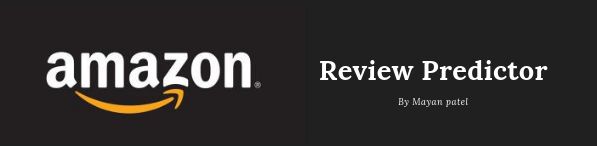

* [Import data](#data)
* [Initial analysis](#firstlook)
    * [UK Dataset](#ukdata)
    * [US Dataset](#usdata)
* [Cleaning](#cleaning)
    * [Remove unnecessary features](#dropfeatures)
    * [Missing values](#missingvalues)
    * [Duplicate reviews](#duplicates)
    * [Data types](#datatypes)
    * [Unique values](#unique)
    * [Outiers](#outliers)
* [Feature engineering](#feature_engineering)
    * [Helpful vote ratio](#helpfulvote)
    * [Review length (words)](#reviewlength)
    * [Camera brand](#brand)
    * [Review sentiment](#reviewsentiment)
* [EDA](#eda)
    * [Time period trends](#time)
    * [Product insights](#producteda)
    * [Helpfulness](#helpfuleda)
    * [Review length](#reviewlengtheda)
    * [Verified purchases](#verifiededa)
    * [Text analysis](#texteda)
    * [Reviewer behaviour](#reviewers)
    * [Correlation heatmap](#correlationheatmap)
* [Web Scraping for current reviews)](#scraping)
    * [Product scraper](#productscraper)
    * [Review scraper](#reviewscraper)
* [Modelling](#modelling)
    * [Baseline accuracy score](#baseline)
    * [Review body as only feature](#reviewbodyonly)
        * [Logistic Regression w/ count Vectoriser](#logregonefeatcvec)
        * [Logistic regression TFIDF](#logregonefeat)
        * [Multinomial Naive Bayes](#nbonefeat)
        * [Random Forest](#randforestonefeat)
        * [Gradient Boosting](#gradboostonefeat)
        * [KNeighborsClassifier](#knnonefeat)
        * [SVM: Support Vector Classifier](#svmonefeat)
    *  [Random Forest only sentiment features](#sentimentforest)
    * [Modelling with additional features](#morefeatures) 
        * [Results comparison](#morefeaturescomparison)
    * [Binary classification problem](#binaryclassification)
    * [Conclusions](#conclusions)
        
       
 
 
     



<a name="data"> </a>
# Import Data and packages


In [251]:
#Download datasets into local folder
#!curl https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_multilingual_UK_v1_00.tsv.gz > amazon_reviews.tsv.gz
#!curl https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Camera_v1_00.tsv.gz > amazon_reviews_us_.tsv.gz

In [4]:
#Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import path

#Visualisation
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

#Web Scraping
import requests
from tqdm import tqdm_notebook
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import time
import random

#Models
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#Natural Language Processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from scipy import sparse
from scipy.sparse import hstack
import textacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction import DictVectorizer

#Preprocessing and metrics
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [5]:
#Amazon US and UK Dataset

#df_uk = pd.read_csv("amazon_review_datasets.tsv/amazon_reviews.tsv", delimiter='\t', error_bad_lines=False)
df_us = pd.read_csv("amazon_review_datasets.tsv/amazon_reviews_us.tsv", delimiter='\t', error_bad_lines=False)


b'Skipping line 85458: expected 15 fields, saw 22\nSkipping line 91161: expected 15 fields, saw 22\n'
b'Skipping line 166123: expected 15 fields, saw 22\n'
b'Skipping line 225458: expected 15 fields, saw 22\nSkipping line 229936: expected 15 fields, saw 22\nSkipping line 259297: expected 15 fields, saw 22\n'
b'Skipping line 284728: expected 15 fields, saw 22\nSkipping line 286334: expected 15 fields, saw 22\nSkipping line 293400: expected 15 fields, saw 22\nSkipping line 294415: expected 15 fields, saw 22\nSkipping line 308150: expected 15 fields, saw 22\nSkipping line 315022: expected 15 fields, saw 22\nSkipping line 315730: expected 15 fields, saw 22\nSkipping line 316071: expected 15 fields, saw 22\nSkipping line 326729: expected 15 fields, saw 22\n'
b'Skipping line 329101: expected 15 fields, saw 22\nSkipping line 333077: expected 15 fields, saw 22\nSkipping line 377031: expected 15 fields, saw 22\nSkipping line 389496: expected 15 fields, saw 22\nSkipping line 390486: expected 15 

<a name="firstlook"> </a>
# Initial analysis

<a name="ukdata"> </a>
## UK Dataset



In [4]:
df_uk.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,UK,10349,R2YVNBBMXD8KVJ,B00MWK7BWG,307651059,My Favourite Faded Fantasy,Music,5,0,0,N,Y,Five Stars,The best album ever!,2014-12-29
1,UK,10629,R2K4BOL8MN1TTY,B006CHML4I,835010224,Seiko 5 Men's Automatic Watch with Black Dial ...,Watches,4,0,0,N,Y,Great watch from casio.,What a great watch. Both watches and strap is ...,2013-10-24
2,UK,12136,R3P40IEALROVCH,B00IIFCJX0,271687675,Dexter Season 8,Digital_Video_Download,5,0,0,N,Y,fantastic,"love watching all the episodes of Dexter, when...",2014-05-09
3,UK,12268,R25XL1WWYRDLA9,B000W7JWUA,211383699,The Settlers of Catan Board Game - discontinue...,Toys,5,0,0,N,Y,Five Stars,Excellent game!!!,2014-09-19
4,UK,12677,RVTVB9YDXSFYH,B005JTAP4S,182965893,Peter: A Darkened Fairytale (Vol 1),Digital_Ebook_Purchase,5,12,12,N,N,A twist on Tales,"This cute, quick read is very different to say...",2013-09-18


In [5]:
#UK dataset consists of multiple categories bundled together. Camera category has 6427 camera reviews
df_uk.product_category.value_counts()

Video DVD                   463202
Music                       329868
Digital_Ebook_Purchase      289120
Books                       257804
Mobile_Apps                 218037
Digital_Video_Download       31423
Digital_Music_Purchase       29264
Toys                         24496
PC                           16258
Camera                        6427
Electronics                   5846
Wireless                      5593
Video                         4580
Baby                          4328
Video Games                   3592
Watches                       3101
Musical Instruments           2832
Home                          2690
Sports                        2336
Shoes                         1718
Office Products                984
Home Improvement               950
Automotive                     530
Health & Personal Care         246
Lawn and Garden                240
Home Entertainment             117
Personal_Care_Appliances       100
Software                        77
Pet Products        

In [6]:
#Set category to Camera in UK Dataset
df_uk = df_uk[ df_uk['product_category'] == "Camera"]
df_uk.shape

(6427, 15)

In [8]:
#Search for camera bodies in the UK dataset
body_only_uk = df_uk[df_uk['product_title'].str.contains('[Bb]ody', regex=True) ]

In [9]:
body_only_uk.shape #Not many results. booo! Conclusion: Unusable for my purposes

(30, 15)

<a name="usdata"> </a>
## US Dataset

In [10]:
#US Dataset consists of only the camera category
df_us.product_category.value_counts()

Camera    1800845
Name: product_category, dtype: int64

In [11]:
df_us.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,2975964,R1NBG94582SJE2,B00I01JQJM,860486164,GoPro Rechargeable Battery 2.0 (HERO3/HERO3+ o...,Camera,5,0,0,N,Y,Five Stars,ok,2015-08-31
1,US,23526356,R273DCA6Y0H9V7,B00TCO0ZAA,292641483,Professional 58mm Center Pinch Lens Cap for CA...,Camera,5,0,0,N,Y,Love it!!!,"Perfect, even sturdier than the original!",2015-08-31
2,US,52764145,RQVOXO7WUOFK6,B00B7733E0,75825744,Spy Tec Z12 Motion Activated Intelligent Secur...,Camera,2,1,1,N,Y,Another Motion Detect Fail,"If the words, &#34;Cheap Chinese Junk&#34; com...",2015-08-31
3,US,47348933,R1KWKSF21PO6HO,B006ZN4U34,789352955,"Celestron UpClose G2 10x25 Monocular, Black (7...",Camera,5,0,0,N,Y,Exactly what I wanted and expected.,Exactly what I wanted and expected. Perfect fo...,2015-08-31
4,US,33680700,R38H3UO1J190GI,B00HUEBGMU,19067902,Vidpro XM-L Wired Lavalier microphone - 20' Au...,Camera,5,1,1,N,Y,Good mic at a Good Price...Not Canon Though.,I will look past the fact that they tricked me...,2015-08-31


In [259]:
#Product search example using ASIN
# df_us[df_us['product_id'] == "B079GDB7C7"] 

In [6]:
#Filter down to reviews with "body only" in the product title. #4260 reviews
# This is when you buy a camera with no lens. Narrows down on camera specific features for comparison



#Alternatively tried to filter by Brand, at this stage
#brands = df_us[df_us['product_title'].str.contains('[Ss]ony|[Cc]anon|[Pp]anasonic|[Ss]amsung|[Ff]ujifilm|[Nn]ikon|[Kk]odak|[Oo]lympus|[Cc]asio|[Kk]onica Minolta|[Pp]entax|[Ll]eica|[Rr]icoh', regex=True) ]

body_only_us = df_us[df_us['product_title'].str.contains('[Bb]ody [Oo]nly', regex=True) ]
len(body_only_us)


4260

In [16]:
#What do these body only values look like? Are they cameras. Looks like it yes!

# for i in body_only_us['product_title'].values:
#     print(i)

body_only_us['product_title'].values[:10]

array(['Sony a7R II Full-Frame Mirrorless Interchangeable Lens Camera, Body Only (Black) (ILCE7RM2/B)',
       'Nikon D750 DSLR Camera (Body Only) + 32GB Extreme Pro Memory Card + Extra Battery and Charger',
       'Sony a7R II Full-Frame Mirrorless Interchangeable Lens Camera, Body Only (Black) (ILCE7RM2/B)',
       'Canon EOS 7D Mark II Digital SLR Camera (Body Only) with Canon Battery Grip BG-E16 and 64GB Deluxe Accessory Kit',
       'Olympus OM-G OMG OM-20 Manual Focus Film Camera; Body Only',
       'Sony a7R II Full-Frame Mirrorless Interchangeable Lens Camera, Body Only (Black) (ILCE7RM2/B)',
       'Sigma SD14 14MP Digital SLR Camera (Body Only)',
       'Nikon D3200 24.2 MP Digital SLR Camera (Body Only) - International Version (No Warranty) (Black, Open Box)',
       'Nikon D3300 24.2 MP CMOS Digital SLR Body Only (Grey) - International Version (No Warranty)',
       'Minolta SRT-101 35mm SLR film camera body only; lens is not included.'],
      dtype=object)

<a name="cleaning"> </a>
# Cleaning

In [17]:
#Continuing with the US dataset camera subset. Check first few reviews
print("Observations",body_only_us.shape)
body_only_us.head()

Observations (4260, 15)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
262,US,30739283,R190J2PDOZ5GVK,B00ZDWGFR2,390090468,Sony a7R II Full-Frame Mirrorless Interchangea...,Camera,3,36,51,N,Y,"Great camera, but there are shortcomings","Great camera, but there are shortcomings : -4...",2015-08-31
917,US,15760475,R3SGZ5G1GJAWVU,B00TSR7YPK,515216474,Nikon D750 DSLR Camera (Body Only) + 32GB Extr...,Camera,5,1,1,N,Y,"This camera is amazing, I have a d610 that I r...","This camera is amazing, I have a d610 that I r...",2015-08-31
1282,US,10861723,R3BWM499VCMGS7,B00ZDWGFR2,390090468,Sony a7R II Full-Frame Mirrorless Interchangea...,Camera,5,48,52,N,Y,Absolutly Must have camera,"Im a Canon guy, but as soon as I found out thi...",2015-08-31
3287,US,22343417,R3SMKIWNMR55UB,B00O29LKN6,474362814,Canon EOS 7D Mark II Digital SLR Camera (Body ...,Camera,5,0,0,N,Y,Canon Digital,I read several review's before my purchase. T...,2015-08-29
4855,US,106593,RNBM8M0T11BV0,B009F2OUOQ,968361935,Olympus OM-G OMG OM-20 Manual Focus Film Camer...,Camera,1,3,3,N,Y,This is only for the camera and strap. There ...,This is only for the camera and strap. There i...,2015-08-29


In [263]:
#Observing some unverfied purchases at the tail of the dataset
body_only_us.tail()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
1800384,US,50475059,R39BUDCLVS7C1W,B00001ZUNQ,830638546,Nikon N60 35mm SLR Camera (Body only),Camera,5,51,55,N,N,NIKON N60 SLR CAMERA,I JUST LOVE MY NEW NIKON N60 SLR CAMERA. WHIL...,2000-01-15
1800443,US,50827136,R2RIUKRW8T3CGW,B00001ZUNQ,830638546,Nikon N60 35mm SLR Camera (Body only),Camera,1,28,57,N,N,N60 lacks features,I was disappointed with the N60. It is a very ...,2000-01-05
1800469,US,50369588,R1D2EW0PL916O9,B00001ZUNQ,830638546,Nikon N60 35mm SLR Camera (Body only),Camera,5,52,54,N,N,Wonderful Pictures,I've owned my Nikon N-60 for about a year now ...,1999-12-30
1800607,US,52003068,R3QVXNRR0AT2RG,B00001ZUNQ,830638546,Nikon N60 35mm SLR Camera (Body only),Camera,5,85,90,N,N,Great Entry Level SLR,I have had the N60 for about 4 months and I ha...,1999-12-01
1800648,US,52637682,R4FVH4JC8X39I,B00001ZUNQ,830638546,Nikon N60 35mm SLR Camera (Body only),Camera,5,116,121,N,N,N60 is a perfect entry level SLR,An excellent choice for anyone looking for an ...,1999-11-23


<a name="dropfeatures"> </a>
## Remove unnecessary features 

In [7]:
#Value counts for the below hold all the same value. Removing as no extra information added.
#Marketplace: US
#Product Category: Camera
#Vine: N
body_only_us.marketplace.value_counts()
body_only_us.product_category.value_counts()
body_only_us.vine.value_counts() 

#Drop the marketplace column and product_category
body_only_us.drop('marketplace', axis=1, inplace=True)  
body_only_us.drop('product_category', axis=1, inplace=True)  
body_only_us.drop('vine', axis=1, inplace=True)  

/Applications/anaconda3/envs/textacy/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<a name="missingvalues"> </a>
## Missing Values

In [25]:
#None
body_only_us.isnull().sum()

customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
star_rating          0
helpful_votes        0
total_votes          0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
dtype: int64

<a name="duplicates"> </a>
## Duplicate Reviews

In [28]:
# No duplicate reviews to remove
body_only_us[body_only_us.duplicated()]

,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date


<a name="datatypes"> </a>
## Data types

In [8]:
# Convert Review_date to datetime. Other features as expected
body_only_us["review_date"] = pd.to_datetime(body_only_us["review_date"])

body_only_us.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4260 entries, 262 to 1800648
Data columns (total 12 columns):
customer_id          4260 non-null int64
review_id            4260 non-null object
product_id           4260 non-null object
product_parent       4260 non-null int64
product_title        4260 non-null object
star_rating          4260 non-null int64
helpful_votes        4260 non-null int64
total_votes          4260 non-null int64
verified_purchase    4260 non-null object
review_headline      4260 non-null object
review_body          4260 non-null object
review_date          4260 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 432.7+ KB


/Applications/anaconda3/envs/textacy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<a name="unique"> </a>
## Unique Values

In [32]:
# Unique value counts

#4620 reviews
print(body_only_us.review_id.value_counts())

# 405 total unique products
print(body_only_us.product_parent.value_counts())

# 2701 verified_purchases and 1559 non verified
print(body_only_us.verified_purchase.value_counts())


R2EP6PWRN1ZKA6    1
R18NJLNOHVQ714    1
R1FQ3GH44F5WDM    1
R2LLMPS683FF35    1
R15ZSBWPJMDMM     1
                 ..
R1UFTT2C0C3F10    1
R2EJ1FXKFSA0E7    1
R1AED8CYR2PPX6    1
R2UTJYY2BSD6BM    1
RKPRWPEZQ7E61     1
Name: review_id, Length: 4260, dtype: int64
804173116    609
779649401    207
454013378    152
5388726      112
627328355    100
            ... 
397935029      1
377276836      1
603661542      1
681360689      1
807106454      1
Name: product_parent, Length: 405, dtype: int64
Y    2701
N    1559
Name: verified_purchase, dtype: int64


<a name="outliers"> </a>
## Outliers

In [33]:
#Numeric columns
body_only_us[['star_rating', 'helpful_votes','total_votes']].describe()

#Star Rating 
#Ranges from 1-5 as expected. Mean rating 4.43 stars and median of 5. This is very high!

#Helpful Votes 
#8.9 average per review. 
# Median of 2 however. Skewed as some reviews may have many.. Max is 1310 (which review was this? check below)

#Total votes
#average 12 per review. 


,star_rating,helpful_votes,total_votes
count,4260.000000,4260.000000,4260.000000
mean,4.439202,8.949061,12.359859
std,1.090768,35.633640,40.687948
min,1.000000,0.000000,0.000000
25%,4.000000,0.000000,1.000000
50%,5.000000,2.000000,3.000000
75%,5.000000,6.000000,9.000000
max,5.000000,1310.000000,1357.000000


In [14]:
#Review with most helpful votes 

body_only_us[body_only_us['helpful_votes']>1000]
print(body_only_us[body_only_us['review_id'] == 'R21UDHF662K69V']['review_headline'].values)
print(body_only_us[body_only_us['review_id'] == 'R21UDHF662K69V']['review_body'].values)

['Does the 7D beat full frame cameras?']
["No, but it's so good that one starts to contemplate this question, which was never the case before the 7D was introduced. Both systems, crop and full frame, have their pros and cons and place in photography. But before I get into that let me say I have not been as excited about a camera since the introduction of the 5D MK I four years ago. That's because the 7D raises the crop camera bar to the point where crop users will not feel at a disadvantage to full frame camera users, especially if coupled with awesome ef-s lenses such as the 17-55 f2.8.<br /><br />How so? The 7D sets a new standard in four major ways.<br /><br />1. It produces whopping 18MP pictures, which are just 3MP shy of the current top of the line full frame Canon cameras. Just few years ago most pros were producing stellar results using the 1Ds MKII 16MP camera. Now you have more MPs in a crop sensor, that's a major achievement. This achievement translates into bigger prints an

In [34]:
body_only_us.columns

Index(['customer_id', 'review_id', 'product_id', 'product_parent',
       'product_title', 'star_rating', 'helpful_votes', 'total_votes',
       'verified_purchase', 'review_headline', 'review_body', 'review_date'],
      dtype='object')

## Cleaned DataFrame

In [9]:
# Rearrange columns
df = body_only_us[['customer_id', 'review_id', 'product_id', 'product_parent',
       'product_title', 'star_rating', 'helpful_votes', 'total_votes',
       'verified_purchase','review_date', 'review_headline', 'review_body']]


In [10]:
df.reset_index(inplace=True, drop=True)
df.head()

,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_date,review_headline,review_body
0,30739283,R190J2PDOZ5GVK,B00ZDWGFR2,390090468,Sony a7R II Full-Frame Mirrorless Interchangea...,3,36,51,Y,2015-08-31,"Great camera, but there are shortcomings","Great camera, but there are shortcomings : -4..."
1,15760475,R3SGZ5G1GJAWVU,B00TSR7YPK,515216474,Nikon D750 DSLR Camera (Body Only) + 32GB Extr...,5,1,1,Y,2015-08-31,"This camera is amazing, I have a d610 that I r...","This camera is amazing, I have a d610 that I r..."
2,10861723,R3BWM499VCMGS7,B00ZDWGFR2,390090468,Sony a7R II Full-Frame Mirrorless Interchangea...,5,48,52,Y,2015-08-31,Absolutly Must have camera,"Im a Canon guy, but as soon as I found out thi..."
3,22343417,R3SMKIWNMR55UB,B00O29LKN6,474362814,Canon EOS 7D Mark II Digital SLR Camera (Body ...,5,0,0,Y,2015-08-29,Canon Digital,I read several review's before my purchase. T...
4,106593,RNBM8M0T11BV0,B009F2OUOQ,968361935,Olympus OM-G OMG OM-20 Manual Focus Film Camer...,1,3,3,Y,2015-08-29,This is only for the camera and strap. There ...,This is only for the camera and strap. There i...


<a name="feature_engineering"> </a>
# Feature Engineering


<a name="helpfulvote"> </a>
## Helpful vote to total vote ratio 

In [11]:
#Signals helpfulness score of a review
df['helpful_ratio'] = df['helpful_votes'] / df['total_votes']

/Applications/anaconda3/envs/textacy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
df.helpful_ratio.fillna(0, inplace=True)
df.helpful_ratio.isnull().sum()

/Applications/anaconda3/envs/textacy/lib/python3.7/site-packages/pandas/core/generic.py:6288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


0

<a name="reviewlength"> </a>
## Review length (words)

In [14]:
# length of review in words. 
df['review_length'] = df['review_body'].apply(lambda x: len(str(x).split(' ')))

/Applications/anaconda3/envs/textacy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<a name="brand"> </a>
## Camera brand 

In [37]:
#Pull the first word out of the product title for the camera brand.
#Group together misspellings and remove observations for outliers

replace_dict = {'silicon':'silicon valley',
                'chrome':'nikon',
                'pentaxistdl':'pentax',
                'pentaxistds2':'pentax',
                'refurbished':'minolta',
               'portable,':'canon',
               '181':'canon',
               '645':'contax',
               'brand':'nikon'}

df['camera_brand'] = df.product_title.map(lambda x: x.split()[0].lower()).replace(replace_dict)

# search through value counts. Plug error in below and find product titles to remove or rename 
# df[df['camera_brand'] == 'phoenix']['product_title'].values 

#findings
df.drop([1327 , 1801, 321, 847, 580, 1395, 1771, 508],inplace=True)


# universal - case remove 1327 1801
# empty - remove this is empty box  - 847
# new - this is an accessory drop it 580
# black - case remove row for camera case  - other two are film cameras also remove 1395 1771
# ardinbir - remove row seems to be an error with a review for accesory photo lamp  508

df['camera_brand'].value_counts() 



/Applications/anaconda3/envs/textacy/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


canon             1330
nikon             1072
sony               465
olympus            320
pentax             312
panasonic          170
vivitar            162
vangoddy           113
minolta             84
fujifilm            51
leica               50
sigma               36
silicon valley      30
samsung             28
hasselblad          12
polaroid             5
kodak                3
ricoh                2
vixen                1
dslrpros             1
phoenix              1
contax               1
lytro                1
toyo                 1
mamiya               1
Name: camera_brand, dtype: int64

<a name="reviewsentiment"> </a>
## Review Sentiment 

In [17]:
analyzer = SentimentIntensityAnalyzer()
vader_scores = df['review_body'].map(analyzer.polarity_scores)
vader_scores.head()

0    {'neg': 0.103, 'neu': 0.768, 'pos': 0.129, 'co...
1    {'neg': 0.0, 'neu': 0.788, 'pos': 0.212, 'comp...
2    {'neg': 0.022, 'neu': 0.707, 'pos': 0.271, 'co...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.185, 'neu': 0.815, 'pos': 0.0, 'comp...
Name: review_body, dtype: object

In [18]:
dvec = DictVectorizer()

vader_scores = dvec.fit_transform(vader_scores)
vader_scores

<4260x4 sparse matrix of type '<class 'numpy.float64'>'
	with 17040 stored elements in Compressed Sparse Row format>

In [96]:
dvec.feature_names_

['compound', 'neg', 'neu', 'pos']

In [19]:
for i, col in enumerate(dvec.feature_names_):
    df['vader_{}'.format(col)] = vader_scores[:, i].toarray().ravel()

/Applications/anaconda3/envs/textacy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
df.head(3)

,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_date,review_headline,review_body,helpful_ratio,review_length,camera_brand,vader_compound,vader_neg,vader_neu,vader_pos
0,30739283,R190J2PDOZ5GVK,B00ZDWGFR2,390090468,Sony a7R II Full-Frame Mirrorless Interchangea...,3,36,51,Y,2015-08-31,"Great camera, but there are shortcomings","Great camera, but there are shortcomings : -4...",0.705882,199,sony,0.8964,0.103,0.768,0.129
1,15760475,R3SGZ5G1GJAWVU,B00TSR7YPK,515216474,Nikon D750 DSLR Camera (Body Only) + 32GB Extr...,5,1,1,Y,2015-08-31,"This camera is amazing, I have a d610 that I r...","This camera is amazing, I have a d610 that I r...",1.000000,21,nikon,0.5100,0.000,0.788,0.212
2,10861723,R3BWM499VCMGS7,B00ZDWGFR2,390090468,Sony a7R II Full-Frame Mirrorless Interchangea...,5,48,52,Y,2015-08-31,Absolutly Must have camera,"Im a Canon guy, but as soon as I found out thi...",0.923077,212,sony,0.9967,0.022,0.707,0.271


<a name="eda"> </a>
# EDA 

<a name="time"> </a>
## Time period trends

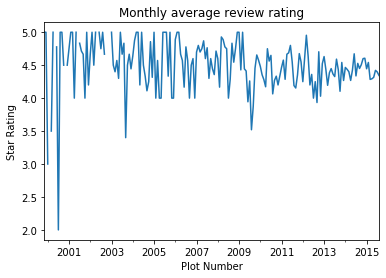

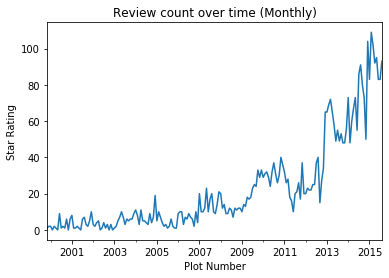

In [38]:
df_time = df.copy()
df_time = df_time.set_index('review_date')

df_time.star_rating.resample('M').mean().plot()
# df_time.star_rating.resample('M').median().plot()
plt.xlabel('Plot Number')
plt.ylabel('Star Rating')
plt.title('Monthly average review rating')
plt.savefig("graphs/time.png", dpi=200, bbox_inches='tight')
plt.show()


df_time.star_rating.resample('M').count().plot()
plt.xlabel('Plot Number')
plt.ylabel('Star Rating')
plt.title('Review count over time (Monthly)')
plt.savefig("graphs/reviewcounttime.png", dpi=200, bbox_inches='tight')
plt.show()



<a name="producteda"> </a>
## Product insights

In [39]:
# Unique product count
print ("{} unique products in the dataset".format(df.product_parent.nunique()), "\n")

397 unique products in the dataset 



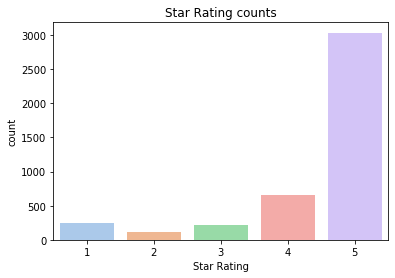

In [40]:
#Most reviews were positive. 

fig, ax = plt.subplots() 
sns.countplot(x='star_rating', data=df, palette='pastel')
plt.xlabel('Star Rating')


plt.title('Star Rating counts')
plt.savefig("graphs/ratings.png", dpi=200, bbox_inches='tight')
plt.show()



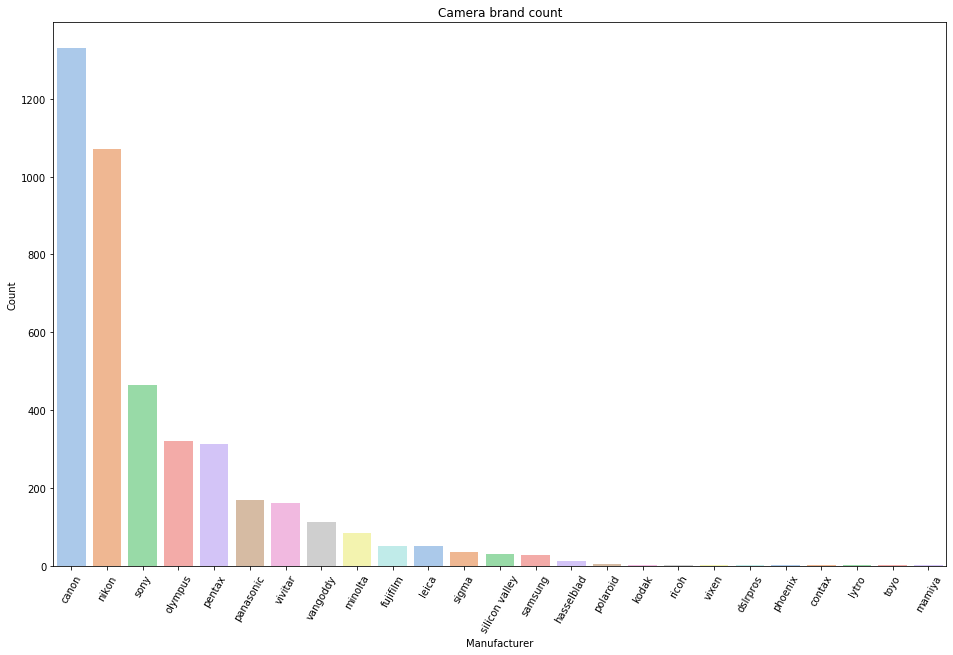

In [41]:
#Most popular brands were Canon, Nikon and Sony

fig, ax = plt.subplots(figsize=(16,10)) 
sns.countplot(x='camera_brand', data=df, palette='pastel', order=df['camera_brand'].value_counts().index)
plt.xlabel('Manufacturer')
plt.xticks(rotation=60)
plt.ylabel('Count')



plt.title('Camera brand count')
plt.savefig("graphs/brands.png", dpi=200, bbox_inches='tight')
plt.show()



In [145]:
#Average review rating by brand 
df.groupby('camera_brand').mean()[['star_rating']].sort_values(by='star_rating', ascending=False)


,star_rating
camera_brand,
vixen,5.000000
lytro,5.000000
dslrpros,5.000000
toyo,5.000000
contax,5.000000
mamiya,5.000000
pentax,4.647436
panasonic,4.594118
olympus,4.559375


In [123]:
#Most reviewed cameras
print("Top 10 most reviewed cameras with review count \n")
for i in df.product_parent.value_counts()[:10].index.tolist():
    print(df.product_parent.value_counts()[i], df[df['product_parent'] == i]['product_title'][:1].values)
 

Top 10 most reviewed cameras with review count 

609 ['Canon EOS 7D 18 MP CMOS Digital SLR Camera Body Only discontinued by manufacturer']
207 ['Nikon D200 10.2MP Digital SLR Camera (Body Only)']
152 ['Olympus 16MP Mirrorless Digital Camera with 3-Inch LCD - Body Only']
112 ['Nikon D800E 36.3 MP CMOS FX-Format Digital SLR Camera (Body Only) (OLD MODEL)']
100 ['Panasonic Lumix DMC-GH3K 16.05 MP Digital Single Lens Mirrorless Camera with 3-Inch OLED - Body Only']
95 ['Vivitar 8 MP Compact System Camera with 2.4-Inch LCD Body Only']
86 ['Canon EOS-10D DSLR Camera (Body Only)']
86 ['Nikon D3200 24.2 MP CMOS Digital SLR - Body Only (Certified Refurbished)']
82 ['Pentax K-5 IIs 16.3 MP DSLR Body Only (Black)']
73 ['Pentax K-7 14.6 MP Digital SLR with Shake Reduction and 720p HD Video (Body Only)']


In [125]:
#Least reviewed cameras - Still seeing a couple bundles and odd accessory
print("Bottom 10 most reviewed products with review count \n")
for i in df.product_parent.value_counts(ascending=True)[:10].index.tolist():
    print(df.product_parent.value_counts(ascending=True)[i], df[df['product_parent'] == i]['product_title'][:1].values)




Bottom 10 most reviewed products with review count 

1 ['Nikon D5200 24.1 MP CMOS Digital SLR Camera Body Only (Bronze) + EN-EL14 Replacement Lithium Ion Battery\xa0w/ External Rapid Charger + 32GB SDHC Class 10 Memory Card + 52mm Wide Angle / Telephoto Lens + 52mm 3 Piece Filter Kit + Mini HDMI Cable + Carrying Case + Full Size Tripod + External Flash + SDHC Card USB Reader + Memory Card Wallet + Deluxe Starter Kit\xa0DavisMAX Bundle']
1 ['Fujifilm X-T1 16 MP Compact System Camera with 3.0-Inch LCD (Body Only)']
1 ['PENTAX K2000 Body Only Kit']
1 ['Nikon D5200 24.1 MP CMOS Digital SLR Camera Body Only (Black) + EN-EL14 Replacement Lithium Ion Battery\xa0w/ External Rapid Charger + 16GB SDHC Class 10 Memory Card + 52mm Wide Angle / Telephoto Lens + 52mm 3 Piece Filter Kit + Mini HDMI Cable + Carrying Case + Full Size Tripod + External Flash + SDHC Card USB Reader + Memory Card Wallet + Deluxe Starter Kit\xa0DavisMAX Bundle']
1 ['Lytro B2-0022 Lithium Ion Battery Pack for Global MP SLR 

<a name="helpfuleda"> </a>
## Helpfulness

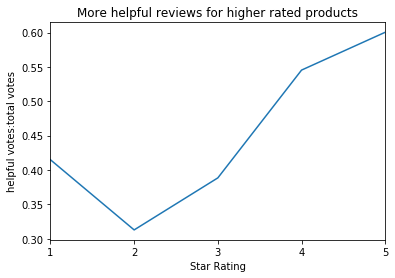

In [42]:
#There are More helpful reviews for higher rated products
df.groupby('star_rating')['helpful_ratio'].mean().plot()

plt.xlabel('Star Rating')
plt.ylabel('helpful votes:total votes')
plt.title('More helpful reviews for higher rated products')
plt.xticks(np.arange(1, 6, step=1))
plt.savefig("graphs/helpfulbyrating.png", dpi=200, bbox_inches='tight')
plt.show()


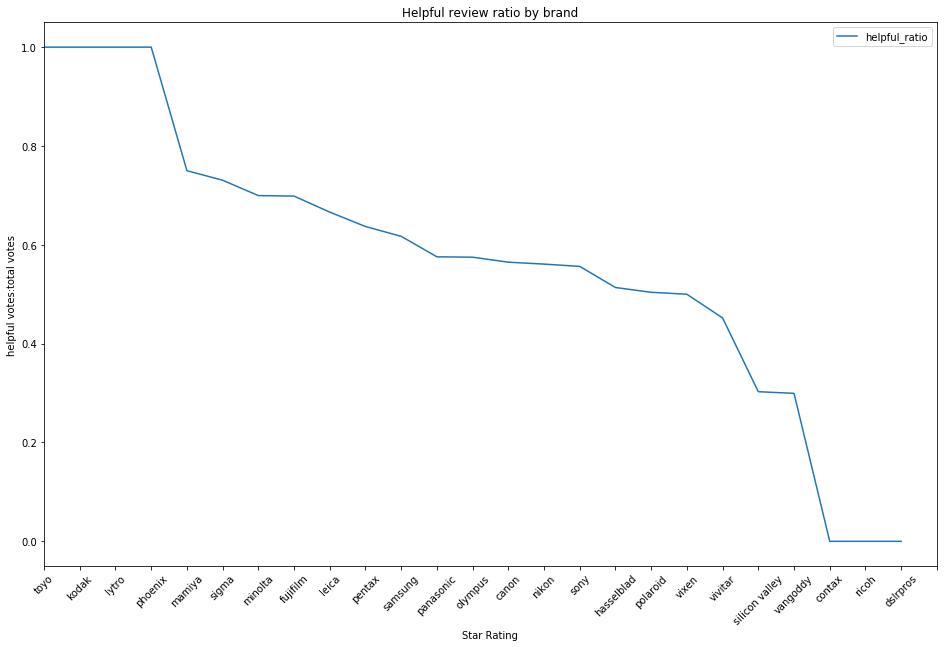

In [43]:
#Helpful review ratio by brand

fig, ax = plt.subplots()
grouped = df.groupby('camera_brand').mean()[['helpful_ratio']].sort_values(
    by='helpful_ratio', ascending=False)
grouped.plot(figsize=(16,10), ax=ax)

ax.set_xlabel('Star Rating')
ax.set_ylabel('helpful votes:total votes')
ax.set_title('Helpful review ratio by brand')
ax.set_xticks(range(26))
ax.set_xticklabels( grouped.index, rotation=45)
fig.savefig("graphs/brandhelpfulratio.png", dpi=200, bbox_inches='tight')
plt.show()


In [306]:
(ax.get_xticks())

array([ 0.,  5., 10., 15., 20., 25.])

In [308]:
grouped.index

Index(['toyo', 'kodak', 'lytro', 'phoenix', 'mamiya', 'sigma', 'minolta',
       'fujifilm', 'leica', 'pentax', 'samsung', 'panasonic', 'olympus',
       'canon', 'nikon', 'sony', 'hasselblad', 'polaroid', 'vixen', 'vivitar',
       'silicon valley', 'vangoddy', 'contax', 'ricoh', 'dslrpros'],
      dtype='object', name='camera_brand')

<a name="reviewlengtheda"> </a>
## Review Length

In [44]:
#Median review is 85 words 
df.review_length.describe()

count    4252.000000
mean      190.542803
std       343.538724
min         1.000000
25%        32.000000
50%        85.000000
75%       218.250000
max      8542.000000
Name: review_length, dtype: float64

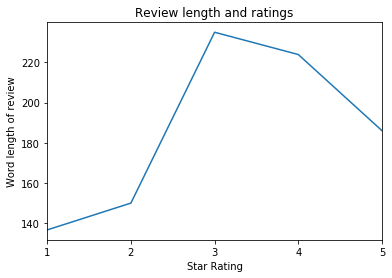

In [45]:
#No obvious trend in review length and rating for each rating
df.groupby('star_rating')['review_length'].mean().plot()

plt.xlabel('Star Rating')
plt.ylabel('Word length of review')
plt.title('Review length and ratings')
plt.xticks(np.arange(1, 6, step=1))
plt.savefig("graphs/reviewlengthratings.png", dpi=200, bbox_inches='tight')
plt.show()

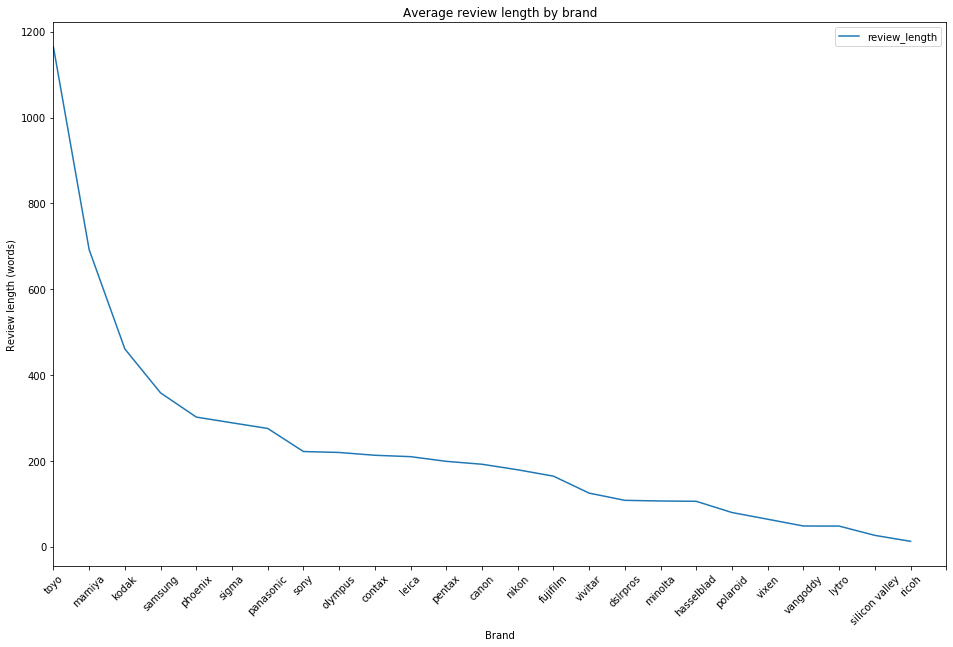

In [46]:

fig, ax = plt.subplots()

grouped2 = df.groupby('camera_brand').mean()[['review_length']].sort_values(by='review_length', ascending=False)
grouped2.plot(figsize=(16,10), ax=ax)

ax.set_xlabel('Brand')
ax.set_ylabel('Review length (words)')
ax.set_title('Average review length by brand')
ax.set_xticks(range(26))
ax.set_xticklabels( grouped2.index, rotation=45)
plt.savefig("graphs/reviewlengthavgbrand.png", dpi=200, bbox_inches='tight')
plt.show()





In [189]:
#How long are the most helpful reviews?
df[df['helpful_ratio'] == 1].sort_values(by='helpful_votes', ascending=False)[['product_title','star_rating', 'helpful_votes','total_votes','helpful_ratio', 'review_length']].head(5)

,product_title,star_rating,helpful_votes,total_votes,helpful_ratio,review_length
3946,Canon EOS 20D DSLR Camera (Body Only) (OLD MODEL),5,96,96,1.0,1507
2546,Nikon D4 16.2 MP CMOS FX Digital SLR with Full...,5,69,69,1.0,579
3506,Nikon D40 6.1MP Digital SLR Camera (Body Only),5,58,58,1.0,1800
4228,Canon EOS Elan IIe Date 35mm SLR Camera (Body ...,5,47,47,1.0,301
3104,Canon EOS Rebel XS 10.1-Megapixel Digital SLR ...,5,35,35,1.0,147


In [67]:
#Are longer reviews more helpful? group into bins? (Redo this plot)

grouped = df.groupby('review_length')[['helpful_ratio']].mean()
#

In [61]:
pd.Series(grouped.index)

0         1
1         2
2         3
3         4
4         5
       ... 
765    3857
766    3933
767    4233
768    5307
769    8542
Name: review_length, Length: 770, dtype: int64

In [70]:
#
grouped['labels'] = pd.qcut(pd.Series(grouped.index), 20)


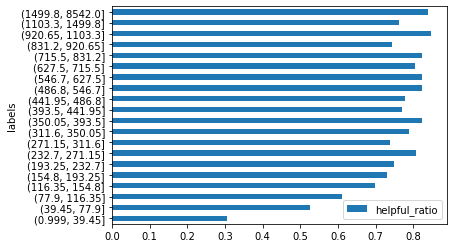

In [76]:

grouped.groupby('labels').mean().plot(kind='barh')
ax.set_xlabel('Brand')
ax.set_ylabel('Review length (words)')
ax.set_title('Average review length by brand')
ax.set_xticks(range(26))
ax.set_xticklabels( grouped2.index, rotation=45)
plt.savefig("graphs/reviewlengthhelpfulness.png", dpi=200, bbox_inches='tight')
plt.show()

<a name="verifiededa"> </a>
## Verified Purchases

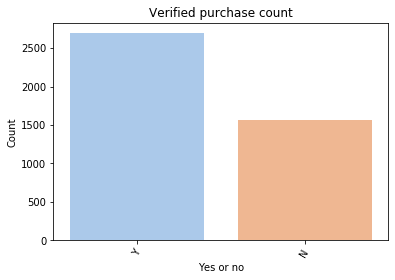

In [163]:
fig, ax = plt.subplots() 
sns.countplot(x='verified_purchase', data=df, palette='pastel', order=df['verified_purchase'].value_counts().index)
plt.xlabel('Yes or no')
plt.xticks(rotation=60)
plt.ylabel('Count')

plt.savefig("graphs/verified.png", dpi=200, bbox_inches='tight')

plt.title('Verified purchase count')

plt.show()




<a name="texteda"> </a>
## Text analysis

There are 118535 words in the combination of all review.


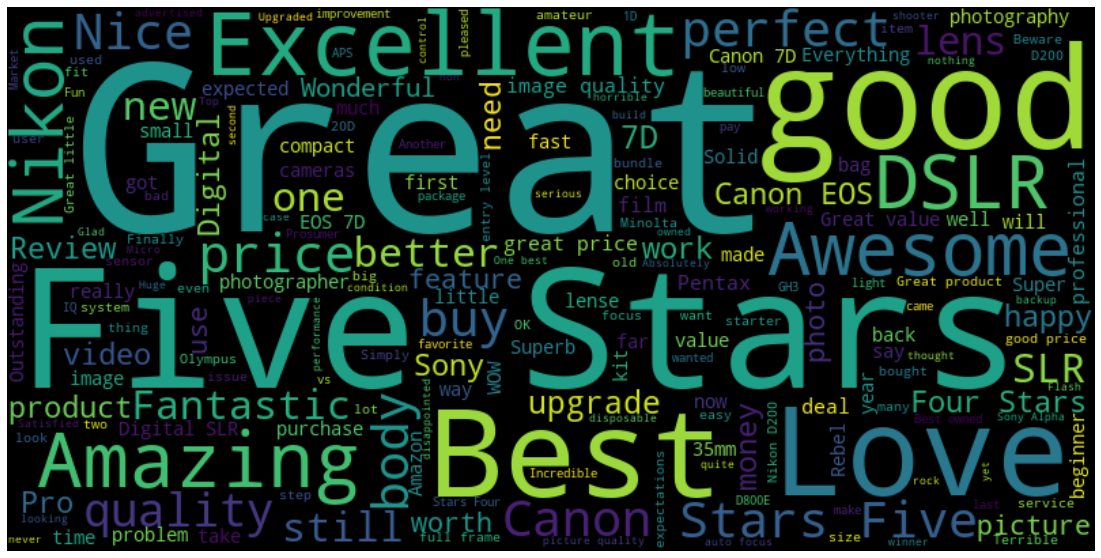

In [172]:
# popular words in review headlines

text = " ".join(review for review in df.review_headline)
print ("There are {} words in the combination of all review.".format(len(text)))

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["camera"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="black", width=800, height=400).generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
wordcloud.to_file("graphs/headline_wordcloud.png")

There are 3802536 words in the combination of all review.


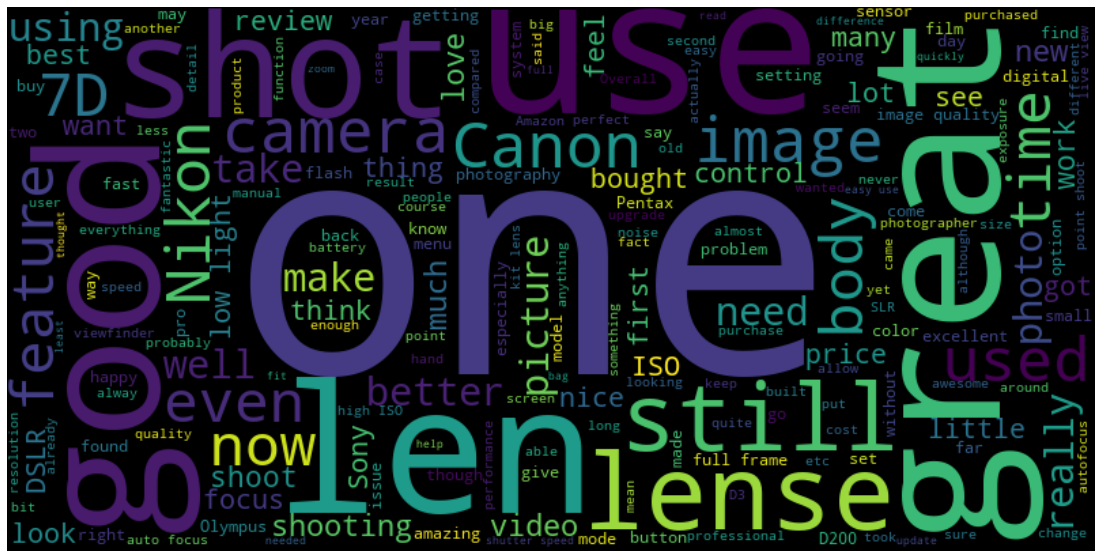

In [173]:
#Popular words in positive reviews 

positive = df[ (df['star_rating'] == 4) | (df['star_rating'] == 5)]

text = " ".join(review for review in positive.review_body)
print ("There are {} words in the combination of all review.".format(len(text)))

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["camera","br","will"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="black", width=800, height=400).generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
wordcloud.to_file("graphs/positive_wordcloud.png")

There are 265922 words in the combination of all review.


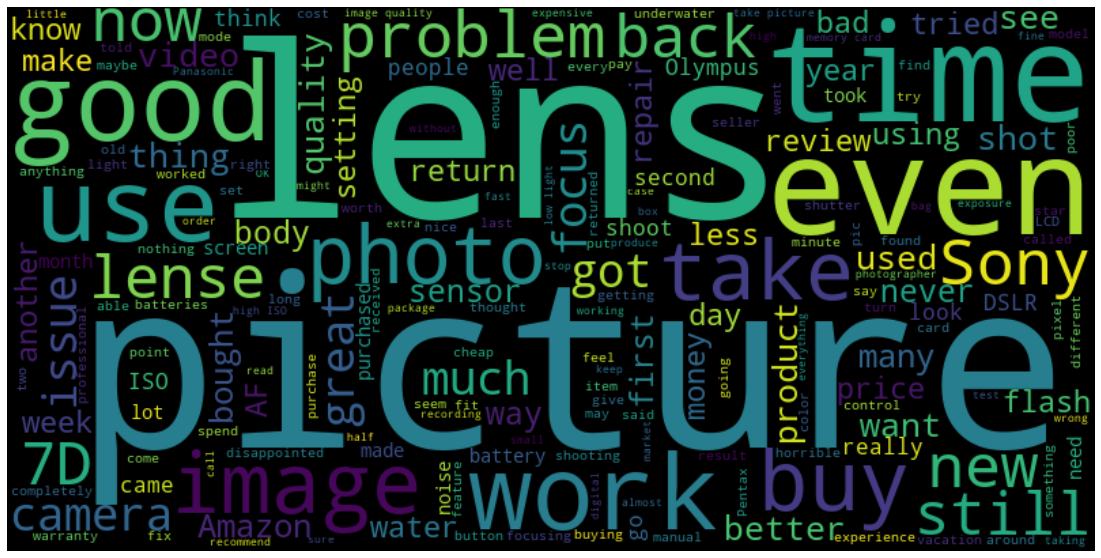

In [177]:
#popular words in negative reviews 

negative = df[ (df['star_rating'] == 1) | (df['star_rating'] == 2)]


text = " ".join(review for review in negative.review_body)
print ("There are {} words in the combination of all review.".format(len(text)))

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["camera","br","will","canon",'Nikon','one'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="black", width=800, height=400).generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Save the image in the img folder:
wordcloud.to_file("graphs/negative_wordcloud.png")

In [202]:
# Let's use the CountVectorizer to count words for us
def get_freq_words(sparse_counts, columns):

    # X_all is a sparse matrix, so sum() returns a 'matrix' datatype ...
    #   which we then convert into a 1-D ndarray for sorting

    word_counts = np.ravel(X_all.sum(axis=0))
    freq_words = pd.Series(
        word_counts, index=columns).sort_values(ascending=False)

    return freq_words

In [203]:
#Custom stopwords 
stop = stopwords.words('english')
stop += ['br']

#expanding the ngram range gives me more specific info. br tags 
cvec = CountVectorizer(stop_words=stop, ngram_range=(2, 4))
X_all = cvec.fit_transform(df['review_body'])
columns = cvec.get_feature_names()

freq_words = get_freq_words(X_all, columns)
freq_words[:30]

#More interesting words
#low light, image quality, auto focus, high iso, live view, white balance, battery life, shutter speed, dynamic range, build quality 
#all popular things covered in professional reviews. 

low light          637
image quality      585
full frame         430
great camera       423
auto focus         341
high iso           296
point shoot        292
kit lens           255
live view          250
camera body        238
love camera        225
white balance      224
easy use           221
picture quality    213
much better        210
shutter speed      200
battery life       198
mark ii            192
digital camera     191
dynamic range      187
digital slr        167
use camera         164
ed af              163
build quality      159
camera great       158
bought camera      151
canon eos          147
manual focus       143
high quality       142
per second         141
dtype: int64

In [218]:
#Frequently occuring phrases for 1* reviews
cvec = CountVectorizer(stop_words=stop, ngram_range=(2, 4))
X_all = cvec.fit_transform(df[df['star_rating'] == 1]['review_body'])
columns = cvec.get_feature_names()

freq_words = get_freq_words(X_all, columns)
freq_words[:30]

memory card         22
customer service    16
camera body         15
image quality       13
high iso            13
fn iii              13
used camera         12
picture quality     12
hot pixels          12
low light           11
piece junk           9
brand new            9
buy camera           9
auto focus           9
purchased camera     9
take pictures        8
camera one           8
camera work          8
digital camera       8
shutter speed        8
could get            8
take picture         8
camera would         8
received camera      7
white balance        7
sd card              7
got camera           7
use camera           7
low iso              7
camera case          7
dtype: int64

In [220]:
#Frequently occuring phrases for 5* reviews
cvec = CountVectorizer(stop_words=stop, ngram_range=(2, 3))
X_all = cvec.fit_transform(df[df['star_rating'] == 5]['review_body'])
columns = cvec.get_feature_names()

freq_words = get_freq_words(X_all, columns)
freq_words[:30]

low light           457
image quality       416
full frame          331
great camera        328
point shoot         244
auto focus          221
high iso            218
love camera         192
live view           188
kit lens            182
easy use            174
ed af               163
camera body         158
picture quality     154
digital camera      153
much better         152
mark ii             147
white balance       137
dynamic range       136
digital slr         135
battery life        134
shutter speed       133
camera great        123
af dx               120
use camera          120
highly recommend    120
canon eos           119
per second          114
build quality       113
depth field         109
dtype: int64

<a name="reviewers"> </a>
## Reviewer behaviour



In [221]:
#Most frequent reviewers 
df['customer_id'].value_counts()[:10]

45664110    6
40109303    6
9115336     5
19541636    4
27140716    4
10572690    4
46160224    4
17237889    3
44250386    3
49410262    3
Name: customer_id, dtype: int64

In [228]:
#Most frequent reviewer left all 4* reviews. They look like affiliate link spam?
df[df['customer_id'] == 45664110]['review_body'].values

array(['For the first-timer or family photographer, the Pentax K-S2 is a nice dSLR, but it drops the ball for video and you should pass on the new 18-50mm kit lens when compared to something like this Nikon here: http://amzn.to/1LnoPdl<br /><br />THE GOOD:<br />+ The Pentax K-S2 offers excellent photo quality, a solid weather-sealed build, a big viewfinder and a broad feature set.<br /><br />THE BAD:<br />- Its video quality is middling to poor.<br /><br />An all-round good Pentax camera offering good quality you would expect but should only be purchased for the image quality aspect as the video shooting leaves some to be desired. If video will be important then maybe try something like this Canon here: http://amzn.to/1dPisGK',
       'For the first-timer or family photographer, the Pentax K-S2 is a nice dSLR, but it drops the ball for video and you should pass on the new 18-50mm kit lens when compared to something like this Nikon here: http://amzn.to/1bA7YcP<br /><br />THE GOOD:<br />

In [230]:
#Reviewers who write the most tend to have a high helpful ratio.
customers = df.groupby('customer_id').mean()[['star_rating','total_votes','helpful_ratio','review_length']].sort_values(by='review_length', ascending=False)
customers.head(10)

,star_rating,total_votes,helpful_ratio,review_length
customer_id,,,,
53089089,5.0,118.0,0.983051,8542.0
47739285,5.0,233.0,0.969957,5307.0
37149793,5.0,239.0,0.983264,3933.0
49055733,5.0,57.0,0.877193,3857.0
47904504,4.0,900.0,0.980000,3830.0
32013796,4.0,153.0,0.993464,3530.0
10550648,5.0,463.0,0.967603,3225.0
12019261,4.0,8.0,0.766667,2752.5
40888222,5.0,75.0,0.986667,2397.0


<a name="correlationheatmap"> </a>
## Correlation heatmap




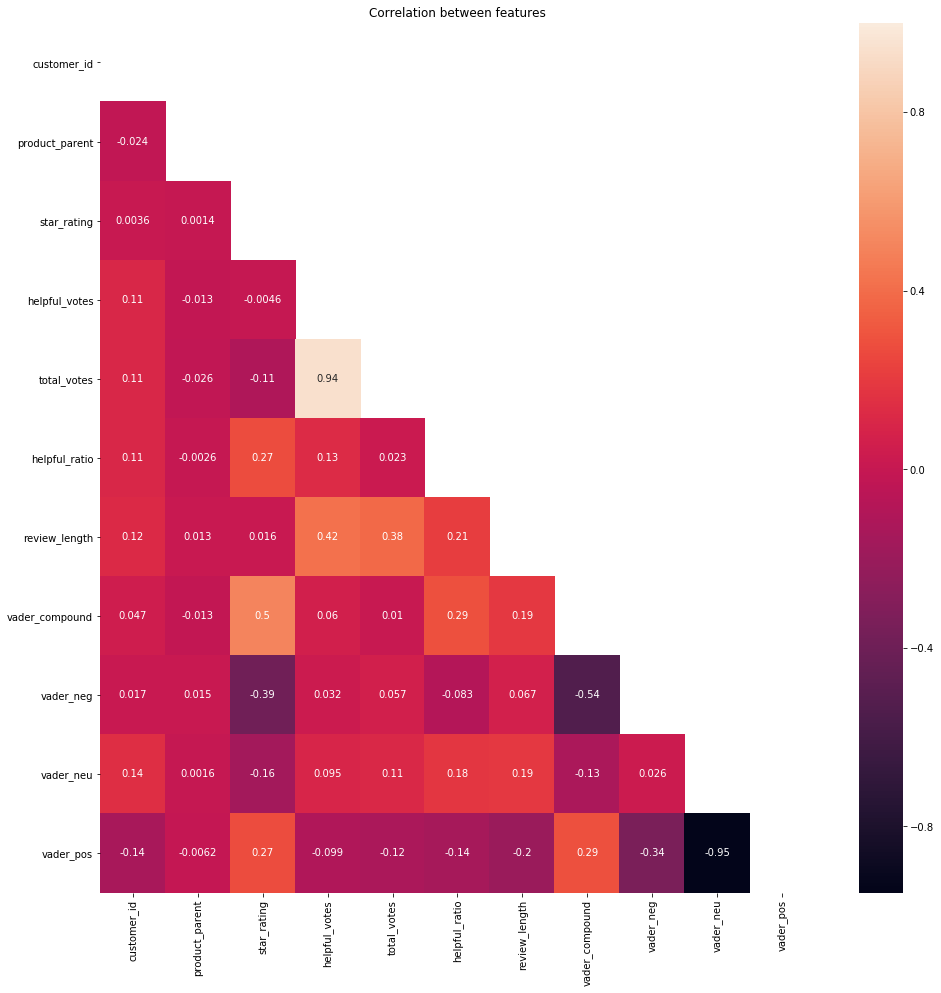

In [235]:
df.corr()

#plot a heatmap with correlation matrix
plt.figure(figsize=(16, 16))

mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df.corr(), annot=True, mask=mask)

plt.savefig("graphs/heatmap.png", dpi=200, bbox_inches='tight')

plt.title('Correlation between features')
# Generate a mask for the upper triangle


plt.show()



In [240]:
# Save df csv
df.to_csv(r'modelling.csv', header=True, index=False)

<a name="scraping"> </a>
# Web Scraping current reviews


<a name="productscraper"> </a>
## Product Scraper by URL

In [237]:
# Future additions 
# Error handling - more try/excepts, timeouts and proxy rotation for concurrent

#e.g
# timeout = 30
# try:
#     WebDriverWait(driver, timeout).until(EC.visibility_of_element_located((By.ID, "mainResults")))
# except TimeoutException:
#     driver.quit()
# # from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC
# from selenium.common.exceptions import TimeoutException

In [93]:
def product_scraper(base_url, page):

    asin = []
    url = []
    product_name = []
    review_count = []
    avg_rating = []
    prices = []
    products = {}

    #FIRST PAGE
    

    driver = webdriver.Chrome(executable_path='./chromedriver')
    driver.get(base_url)
    #Save page source into Beautiful Soup
    Soup = BeautifulSoup(driver.page_source,'html.parser')
    #select each product listing
    first_page_results = Soup.select('#mainResults > ul > li')

    #in each product listing extract   
    
    for item in first_page_results:
        
        try:
            asin.append(item.attrs['data-asin'])
        except: 
            asin.append(np.nan)
        
        try:
             url.append(item.find('a').attrs['href'])
        except:
            url.append(np.nan)
        
        try:
            product_name.append(item.find('h2').attrs['data-attribute'])
        except:
            product_name.append(np.nan)
            
        try:
            avg_rating.append(item.find('span', class_ = 'a-icon-alt').text)
        except:
            avg_rating.append(np.nan)
        
        try:
            review_count.append(item.find_all('a','a-size-small')[-1].text) 
        except:
            review_count.append(np.nan)
        
        try:
            prices.append(item.find('span','sx-price-whole').text + "." + item.find('sup','sx-price-fractional').text)
       
        except:
            prices.append(np.nan)
    
    
    #After running the first page sleep, and click to the next page

    time.sleep(2.5)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(1.0)
    next_button = driver.find_element_by_xpath("//*[@id='pagnNextLink']")
    next_button.click()

    
    
    #SECOND PAGE FUNCTION
    def get_morepages():
        
        
         
        Soup2 = BeautifulSoup(driver.page_source,'html.parser')
    
        all_results_pg2 = Soup2.find_all('div','s-result-item')

        for item in all_results_pg2:
        
            try:
                asin.append(item.attrs['data-asin'])       
            except:
                asin.append(np.nan)
            
            try:
                url.append("https://www.amazon.com" + item.find('a').attrs['href'])
            except:
                url.append(np.nan)
            
            try:
                product_name.append(item.find('span', 'a-size-medium').text)
                
            except:
                product_name.append(np.nan)
                
            
            try:
                avg_rating.append(item.find('span', class_ = 'a-icon-alt').text)

            except:
                avg_rating.append(np.nan)
            
            try:
                review_count.append(item.find('span','a-size-base').text) 

            except:
                review_count.append(np.nan)
    
            try:
                prices.append(item.find('span','a-price-whole').text + item.find('span','a-price-fraction').text)
       
            except:
                prices.append(np.nan)
    
    ()
    
    #set parameter for range of pages to loop 
    for i in range(1,page):
        time.sleep(random.randint(6,10)) #random waiting time between 6 and 10 seconds
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        get_morepages() #run scraper for the page 
        time.sleep(1.0)
        next_button = driver.find_element_by_xpath("//*[@class='a-last']") #update with new link
        next_button.click()
        

    #create dictionary from lists  
    products = {'ASIN':asin,'URL':url, 'Product':product_name, 'Reviews':review_count,'Rating':avg_rating, 'Price':prices}
    
    
    #create DataFrame
    df_clean = pd.DataFrame(products)

    #data cleaning

    print("observations before cleaning",df_clean.shape)
    #Remove missing values
    df_clean.dropna(inplace=True)
    


    #Remove commas for large reviews and prices 
    df_clean['Reviews'] = df_clean['Reviews'].str.replace(",","")
    df_clean['Price'] = df_clean['Price'].str.replace(",","")

    #Splice only value of rating
    df_clean['Rating'] = df_clean.Rating.str.split(" ", 1, expand=True)[0]

    #adjusting data types
    df_clean.Reviews = df_clean.Reviews.astype(int)
    df_clean.Rating = df_clean.Rating.astype(float)
    df_clean.Price = df_clean.Price.astype(float)

    #remove duplicates by multiple ASIN
    df_clean = df_clean.sort_values(by='ASIN')
    df_clean = df_clean.drop_duplicates(subset='ASIN')
    

   

    print("observations after cleaning",df_clean.shape)
    
    #SAVE TO CSV CLEANED DATA
    
    df_clean.to_csv(r'cameras.csv', mode='a', header=True, index=False)  


In [7]:
#Amazon first page urls for categories of cameras
DSLR = 'https://www.amazon.com/s?i=photo&rh=n%3A172282%2Cn%3A493964%2Cn%3A502394%2Cn%3A281052%2Cn%3A3017941&page=1&qid=1566759904&ref=sr_pg_1'
MIRRORLESS = 'https://www.amazon.com/Mirrorless-Cameras/b/?ie=UTF8&node=3109924011&ref_=sv_camera_4'
ACTION = 'https://www.amazon.com/Sports-Action-Video-Cameras/b/?ie=UTF8&node=7161074011&ref_=sv_camera_7'
POINTANDSHOOT = 'https://www.amazon.com/Digital-Cameras-Photo/b/?ie=UTF8&node=330405011&ref_=sv_camera_6'

#running product scraper that saves CSV in local folder
product_scraper(POINTANDSHOOT, 20)


observations before cleaning (328, 6)
observations after cleaning (264, 6)


## Reviews scraper by ASIN
<a name="reviewscraper"> </a>

In [94]:
def review_scraper(asin, reviewpages): 

    #Get URL and goto page
    driver = webdriver.Chrome(executable_path='./chromedriver')
    driver.get('https://www.amazon.com/gp/product/{}'.format(asin))

    #scroll to bottom of page and sleep 
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2.0)

    #navigate to all reviews page 
    next_button = driver.find_element_by_xpath('//*[@id="reviews-medley-footer"]/div[2]/a') 
    try:
        next_button.click()
    except:
        time.sleep(30.5)
        try:
            next_button.click()
        except:
            driver.find_element_by_partial_link_text('Next').click()
            
        

    

    #In review section scrape all details 
    profile_name = []
    user_url_id = []
    review_date = []
    star_rating = []
    review_title = []
    helpful_votes = []
    total_comments = []
    verified_purchase = []
    review_body = []
    review_id = []

    def review_scraper_inner():
        
        #Scrape page source
        Soup = BeautifulSoup(driver.page_source,'html.parser')
        
   
    
    
        
        for review in Soup.find_all(attrs={"data-hook" : "review"}):
            
            
            try:
                review_id.append(review.attrs['id'])
            except:
                review_id.append(np.nan)

            try:
                profile_name.append(review.find("span", "a-profile-name").text)
            except:
                profile_name.append(np.nan)


            try:
                user_url_id.append(review.find("a","a-profile").attrs['href'])
            except:
                user_url_id.append(np.nan)

            try:
                review_date.append(review.find(attrs={"data-hook" : "review-date"}).text)
            except:
                review_date.append(np.nan)

            try:
                star_rating.append(review.find("span", "a-icon-alt").text)
            except:
                star_rating.append(np.nan)

            try:
                review_title.append(review.find(attrs={"data-hook" : "review-title"}).text.strip())
            except:
                review_title.append(np.nan)

            try:
                helpful_votes.append(review.find(attrs={"data-hook" : "helpful-vote-statement"}).text)
            except:
                helpful_votes.append(np.nan)

            try:
                total_comments.append(review.find("span","review-comment-total").text)
            except:
                total_comments.append(np.nan)

            try:
                verified_purchase.append(review.find(attrs={"data-hook" : "avp-badge"}).text)
            except:
                verified_purchase.append(np.nan)

            try:
                review_body.append(review.find(attrs={"data-hook" : "review-body"}).text)
            except:
                review_body.append(np.nan)

    
    reviewpages = reviewpages+1
    #set parameter for range of pages to loop 
    for i in range(1,reviewpages):
        
        time.sleep(random.randint(4,7)) #random waiting time between 6 and 10 seconds
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1.5)
        review_scraper_inner() #run scraper for the page 
        time.sleep(2.5)
#         driver.find_element_by_xpath('//*[@class="a-last"]/a').click()
#         driver.find(attrs={"data-hook" : "see-all-reviews-link-foot"}).click()
        try:
            driver.find_element_by_partial_link_text('Next').click()
        except:
            time.sleep(30.5)
            try:
                driver.find_element_by_partial_link_text('Next').click()
            except:
                driver.find_element_by_xpath('//*[@id="reviews-medley-footer"]/div[2]/a').click()
        
        
        
    #create dictionary from lists  
    reviews = {'ASIN':asin, 'review_id':review_id, 'profile_name': profile_name,'user_url_id':user_url_id,'review_date':review_date,'star_rating': star_rating,'review_title':review_title,'helpful_votes':helpful_votes,'total_comments':total_comments,'verified_purchase':verified_purchase,'review_body':review_body     }


    #create DataFrame
    df_reviews = pd.DataFrame(reviews)

    #data cleaning
    
    
    print("observations before cleaning",df_reviews.shape)
    
    #Won't remove missing values - Verified purchase may be missing. check this from sample data
    
    #Splice only value of rating
    
    try:
        df_reviews['star_rating'] = df_reviews.star_rating.str.split(".", 1, expand=True)[0]
    except:
        df_reviews['star_rating'] = df_reviews.star_rating
        print('error cleaning star rating')
        
    try:
        df_reviews['helpful_votes'] = df_reviews.helpful_votes.str.split(" ", 1, expand=True)[0]
    except:
        df_reviews['helpful_votes'] = df_reviews.helpful_votes
        print('error cleaning helpful votes')
    
    try:
        df_reviews['total_comments'] = df_reviews.total_comments.str.split(" ", 1, expand=True)[0]
    except:
        df_reviews['total_comments'] = df_reviews.total_comments
        print('error cleaning total_comments')
        


        
        
    #Remove commas for large reviews and prices 
    
    try:
        df_reviews['helpful_votes'] = df_reviews['helpful_votes'].str.replace(",","")
    except:
        df_reviews['helpful_votes'] = df_reviews['helpful_votes']
        print('error cleaning helpful votes commas')
    
    try:
        df_reviews['total_comments'] = df_reviews['total_comments'].str.replace(",","")
    except:
        df_reviews['total_comments'] = df_reviews['total_comments']
        print('error cleaning total_comments commas')


    #adjusting data types

#     df_reviews.star_rating = df_reviews.star_rating.astype(int)
    
#     try:
#         df_reviews.helpful_votes = df_reviews.helpful_votes.astype(int)
    
#     except:
        
#     try:
#         df_reviews.total_comments = df_reviews.total_comments.astype(int)
    
#     except:
        

    #remove duplicates by reviewID
    df_reviews = df_reviews.sort_values(by='review_id')
    df_reviews = df_reviews.drop_duplicates(subset='review_id')
    

   

    print("observations after cleaning",df_reviews.shape)
    
    
    


    #SAVE TO CSV CLEANED DATA from list
    df_reviews.to_csv(r'reviews.csv', mode='a', header=True, index=False)
    
    driver.close()
    

In [239]:
#Test run
asin = 'B01BUYK04A'
reviewpages = 4
review_scraper(asin, reviewpages)

## Text Preprocessing (revisit after modelling to see if improves scores)

In [ ]:
#     Text Preprocessing.
#             a. Converting to lower-case. VADER treats caps with more weight
#             b. Removing HTML Tags. Only <br>
#             c. Removing Special Characters. Are some useful e.g ! emphasises
#             d. Removing Stop Words. Yes
#             e. Stemming (Snowball Stemming)

<a name="modelling"> </a>
# Modelling 



In [83]:
#load csv 
df = pd.read_csv("modelling.csv")


#nan values prevent modelling place this earlier in cleaning and resave .csv
df.helpful_ratio.fillna(0,inplace=True) 

<a name="baseline"> </a>
## Baseline accuracy score

In [84]:
y = df['star_rating']

In [85]:
#0.7135 very high due to class imbalance of 5 star ratings
y.value_counts(normalize=True) 

5    0.713547
4    0.153104
1    0.057385
3    0.050094
2    0.025870
Name: star_rating, dtype: float64

<a name="reviewbodyonly"> </a>
## Review body as only feature 

In [55]:
# Set predictor variables
X = df['review_body']

In [56]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                             test_size=0.2,
                                             stratify=y, random_state=1)
print( y_train.shape,X_train.shape, y_test.shape,X_test.shape )

(3401,) (3401,) (851,) (851,)


In [18]:
#Set up Bag of words matrices with Count Vectoriser and TFIDF

In [57]:
stop = stopwords.words('english')
stop += ['br']

# Setting the vectorizer just like we would set a model
cvec = CountVectorizer(stop_words=stop, ngram_range=(2, 4))

# Fitting the vectorizer on review_body in training data
cvec.fit(X_train)

# Transform training data into sparse matrix
cvec_ma = cvec.transform(X)

# Transform training data into sparse matrix
cvec_mat_train = cvec.transform(X_train)

# Transform test data into sparse matrix
cvec_mat_test = cvec.transform(X_test)

In [58]:
# words occuring
words = cvec.get_feature_names()
print(words[5000:5020])
# number of different words
print(len(words))

['135mm likely going often', '135mm long', '135mm long portrait', '135mm long portrait prime', '135mm sigma', '135mm sigma lens', '135mm sigma lens bit', '135mm ud', '135mm ud standard', '135mm ud standard zoom', '135mm usm', '135mm usm standard', '135mm usm standard zoom', '135mm would', '135mm would probably', '135mm would probably better', '135mm wr', '135mm wr lens', '135mm wr lens video', '137 contax']
761730


In [59]:
#TFIDF vectoriser

# Setting the vectorizer just like we would set a model
tfidf = TfidfVectorizer(stop_words= stopwords.words('english'), min_df=0.0005)

# Fitting the vectorizer on our training data review_body
tfidf.fit(X_train)

# Transform training data into sparse matrix
tfidf_mat_train = tfidf.transform(X_train) 

# Transform test data into sparse matrix
tfidf_mat_test = tfidf.transform(X_test)


In [60]:
#TFIDF weights -- further analysis https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.XXUSWC2ZPhM 

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(cvec_mat_train)


# print idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cvec.get_feature_names(),columns=["idf_weights"])
 
# sort ascending
df_idf.sort_values(by=['idf_weights'])[:20]

,idf_weights
great camera,3.303173
low light,3.357567
image quality,3.441759
full frame,3.733956
auto focus,3.955969
point shoot,3.967333
love camera,3.967333
camera body,4.026173
easy use,4.032252
high iso,4.069524


<a name="logregonefeatcvec"> </a>
### Logistic Regression CVEC


In [61]:
pipeline = Pipeline([
    ('vect', cvec),
    #('tfidf', TfidfTransformer()),
    ('cls', LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000, class_weight='balanced'))
])
pipeline.fit(X_train, y_train)

print("Test set score", pipeline.score(X_test, y_test))
scores = cross_val_score(pipeline, X_train, y_train, cv=3)
print('Cross validation training score:', scores.mean())

#Confusion Matrix and classification report

predictions_test = pipeline.predict(X_test)
predictions_train = pipeline.predict(X_train)
confusion = pd.DataFrame(confusion_matrix(y_test, predictions_test),
             index=['True 1', 'True 2','True 3','True 4','True 5'],
             columns=['p1', 'p2','p3','p4','p5'])

probs = pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, predictions_test, digits=4 ))
confusion

Test set score 0.7109283196239718
Cross validation training score: 0.7094977186738419
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        49
           2     0.0000    0.0000    0.0000        22
           3     0.0000    0.0000    0.0000        43
           4     0.3750    0.0231    0.0435       130
           5     0.7158    0.9918    0.8315       607

   micro avg     0.7109    0.7109    0.7109       851
   macro avg     0.2182    0.2030    0.1750       851
weighted avg     0.5679    0.7109    0.5997       851



/Applications/anaconda3/envs/textacy/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,p1,p2,p3,p4,p5
True 1,0,0,0,1,48
True 2,0,0,0,0,22
True 3,0,0,0,0,43
True 4,0,1,0,3,126
True 5,1,0,0,4,602


<a name="logregonefeat"> </a>
###  LogisticRegression TFIDF

In [62]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('cls', LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000, class_weight='balanced'))
])
pipeline.fit(X_train, y_train)

print("Test set score", pipeline.score(X_test, y_test))
scores = cross_val_score(pipeline, X_train, y_train, cv=3)
print('Cross validation training score:', scores.mean())

#Confusion Matrix and classification report

predictions_test = pipeline.predict(X_test)
predictions_train = pipeline.predict(X_train)
confusion = pd.DataFrame(confusion_matrix(y_test, predictions_test),
             index=['True 1', 'True 2','True 3','True 4','True 5'],
             columns=['p1', 'p2','p3','p4','p5'])

probs = pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, predictions_test, digits=4 ))
confusion

Test set score 0.699177438307873
Cross validation training score: 0.6791946558420549
              precision    recall  f1-score   support

           1     0.5909    0.7959    0.6783        49
           2     0.3333    0.0909    0.1429        22
           3     0.2432    0.2093    0.2250        43
           4     0.2952    0.3769    0.3311       130
           5     0.8611    0.8171    0.8385       607

   micro avg     0.6992    0.6992    0.6992       851
   macro avg     0.4648    0.4580    0.4431       851
weighted avg     0.7142    0.6992    0.7028       851



,p1,p2,p3,p4,p5
True 1,39,0,4,4,2
True 2,7,2,2,10,1
True 3,7,1,9,12,14
True 4,6,2,10,49,63
True 5,7,1,12,91,496


<a name="nbonefeat"> </a>
###  Multinomial Naive Bayes 

In [63]:
pipeline = Pipeline([
     ('tfidf', TfidfVectorizer()),
    ('cls', MultinomialNB())
])
pipeline.fit(X_train, y_train)

print("Test set score", pipeline.score(X_test, y_test))
scores = cross_val_score(pipeline, X_train, y_train, cv=3)
print('Cross validation training score:', scores.mean())

#Confusion Matrix and classification report

predictions_test = pipeline.predict(X_test)
predictions_train = pipeline.predict(X_train)
confusion = pd.DataFrame(confusion_matrix(y_test, predictions_test),
             index=['True 1', 'True 2','True 3','True 4','True 5'],
             columns=['p1', 'p2','p3','p4','p5'])

probs = pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, predictions_test, digits=4 ))
confusion

Test set score 0.7132784958871915
Cross validation training score: 0.713614507140362
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        49
           2     0.0000    0.0000    0.0000        22
           3     0.0000    0.0000    0.0000        43
           4     0.0000    0.0000    0.0000       130
           5     0.7133    1.0000    0.8326       607

   micro avg     0.7133    0.7133    0.7133       851
   macro avg     0.1427    0.2000    0.1665       851
weighted avg     0.5088    0.7133    0.5939       851



/Applications/anaconda3/envs/textacy/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,p1,p2,p3,p4,p5
True 1,0,0,0,0,49
True 2,0,0,0,0,22
True 3,0,0,0,0,43
True 4,0,0,0,0,130
True 5,0,0,0,0,607


<a name="randforestonefeat"> </a>
### Random Forest

In [64]:
# Random Forest
pipeline = Pipeline([
#     ('vect', cvec),
    #('tfidf', TfidfTransformer()),
     ('tfidf', TfidfVectorizer()),
    ('cls', RandomForestClassifier(n_estimators=200, class_weight='balanced'))
])
pipeline.fit(X_train, y_train)

print("Test set score", pipeline.score(X_test, y_test))
scores = cross_val_score(pipeline, X_train, y_train, cv=3)
print('Cross validation training score:', scores.mean())

#Confusion Matrix and classification report

predictions_test = pipeline.predict(X_test)
predictions_train = pipeline.predict(X_train)
confusion = pd.DataFrame(confusion_matrix(y_test, predictions_test),
             index=['True 1', 'True 2','True 3','True 4','True 5'],
             columns=['p1', 'p2','p3','p4','p5'])

probs = pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, predictions_test, digits=4 ))
confusion

Test set score 0.7168037602820212
Cross validation training score: 0.7115579285275343
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        49
           2     0.0000    0.0000    0.0000        22
           3     0.0000    0.0000    0.0000        43
           4     1.0000    0.0231    0.0451       130
           5     0.7166    1.0000    0.8349       607

   micro avg     0.7168    0.7168    0.7168       851
   macro avg     0.3433    0.2046    0.1760       851
weighted avg     0.6639    0.7168    0.6024       851



/Applications/anaconda3/envs/textacy/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,p1,p2,p3,p4,p5
True 1,0,0,0,0,49
True 2,0,0,0,0,22
True 3,0,0,0,0,43
True 4,0,1,0,3,126
True 5,0,0,0,0,607


<a name="gradboostonefeat"> </a>
### Gradient Boosting

In [41]:
# # Gradient Boosting (taking too long to run)
# pipeline = Pipeline([
#     ('vect', cvec),
#     #('tfidf', TfidfTransformer()),
#     ('cls', GradientBoostingClassifier(n_estimators=200))
# ])
# pipeline.fit(X_train["review_body"], y_train)
# print("Test set score", pipeline.score(X_test["review_body"], y_test))
# scores = cross_val_score(pipeline, X_train["review_body"], y_train, cv=3)
# print('Cross validation training score:', scores.mean())

# #Confusion Matrix and classification report

# predictions_test = pipeline.predict(X_test["review_body"])
# predictions_train = pipeline.predict(X_train["review_body"])
# confusion = pd.DataFrame(confusion_matrix(y_test, predictions_test),
#              index=['True 1', 'True 2','True 3','True 4','True 5'],
#              columns=['p1', 'p2','p3','p4','p5'])

# probs = pipeline.predict_proba(X_test["review_body"])[:, 1]

# print(classification_report(y_test, predictions_test, digits=4 ))
# confusion

<a name="knnonefeat"> </a>
### KNeighborsClassifier

In [65]:
pipeline = Pipeline([
#     ('vect', cvec),
    #('tfidf', TfidfTransformer()),
    ('tfidf', TfidfVectorizer()),
    ('cls', KNeighborsClassifier(n_neighbors=5))
])
pipeline.fit(X_train, y_train)

print("Test set score", pipeline.score(X_test, y_test))
scores = cross_val_score(pipeline, X_train, y_train, cv=3)
print('Cross validation training score:', scores.mean())

#Confusion Matrix and classification report

predictions_test = pipeline.predict(X_test)
predictions_train = pipeline.predict(X_train)
confusion = pd.DataFrame(confusion_matrix(y_test, predictions_test),
             index=['True 1', 'True 2','True 3','True 4','True 5'],
             columns=['p1', 'p2','p3','p4','p5'])

probs = pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, predictions_test, digits=4 ))
confusion

Test set score 0.6803760282021152
Cross validation training score: 0.6983179470940835
              precision    recall  f1-score   support

           1     0.6667    0.1224    0.2069        49
           2     0.0000    0.0000    0.0000        22
           3     0.0000    0.0000    0.0000        43
           4     0.1154    0.0462    0.0659       130
           5     0.7223    0.9341    0.8147       607

   micro avg     0.6804    0.6804    0.6804       851
   macro avg     0.3009    0.2205    0.2175       851
weighted avg     0.5712    0.6804    0.6031       851



/Applications/anaconda3/envs/textacy/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,p1,p2,p3,p4,p5
True 1,6,0,0,6,37
True 2,0,0,2,1,19
True 3,1,0,0,2,40
True 4,0,0,2,6,122
True 5,2,0,1,37,567


<a name="svmonefeat"> </a>
### SVM: Support Vector Classifier

In [67]:
pipeline = Pipeline([
#     ('vect', cvec),
    #('tfidf', TfidfTransformer()),
    ('tfidf', TfidfVectorizer()),
    ('cls', svm.SVC(class_weight='balanced', gamma='auto', kernel='linear'))
])
pipeline.fit(X_train, y_train)

print("Test set score", pipeline.score(X_test, y_test))
scores = cross_val_score(pipeline, X_train, y_train, cv=3)
print('Cross validation training score:', scores.mean())

#Confusion Matrix and classification report

predictions_test = pipeline.predict(X_test)
predictions_train = pipeline.predict(X_train)
confusion = pd.DataFrame(confusion_matrix(y_test, predictions_test),
             index=['True 1', 'True 2','True 3','True 4','True 5'],
             columns=['p1', 'p2','p3','p4','p5'])

# probs = pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, predictions_test, digits=4 ))
confusion

Test set score 0.6568742655699178
Cross validation training score: 0.6442162363303069
              precision    recall  f1-score   support

           1     0.5217    0.7347    0.6102        49
           2     0.2000    0.0455    0.0741        22
           3     0.1176    0.0930    0.1039        43
           4     0.2626    0.4000    0.3171       130
           5     0.8550    0.7677    0.8090       607

   micro avg     0.6569    0.6569    0.6569       851
   macro avg     0.3914    0.4082    0.3828       851
weighted avg     0.6912    0.6569    0.6678       851



,p1,p2,p3,p4,p5
True 1,36,0,4,4,5
True 2,8,1,1,11,1
True 3,9,1,4,16,13
True 4,7,1,10,52,60
True 5,9,2,15,115,466


<a name="sentimentforest"> </a>
## Random Forest with sentiment features

In [69]:
X = df[['vader_compound','vader_pos','vader_neg']].astype(float)
y = df['star_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_s = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced')

params = {
    'criterion': ['entropy', 'gini'],
    'max_features': np.linspace(0.1,1.0, 10),
}


gs = GridSearchCV(rf, params, n_jobs=-1, cv=5, verbose=1, iid=False)
gs.fit(X_train_s, y_train)


print("training score:", gs.score(X_train_s, y_train))
print("test score:", gs.score(X_test_s, y_test))
print("best parameters:",gs.best_params_)


#Classification report and confusion Matrix
predictions_test = gs.predict(X_test_s)
predictions_train = gs.predict(X_train_s)

confusion = pd.DataFrame(confusion_matrix(y_test, predictions_test),
             index=['True 1', 'True 2','True 3','True 4','True 5'],
             columns=['p1', 'p2','p3','p4','p5'])

probs = gs.predict_proba(X_test_s)[:, 1]

print(classification_report(y_test, predictions_test, digits=4 ))
confusion

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.7s finished


training score: 0.9711849456042341
test score: 0.6733254994124559
best parameters: {'criterion': 'entropy', 'max_features': 0.6}
              precision    recall  f1-score   support

           1     0.2692    0.2857    0.2772        49
           2     0.1429    0.0455    0.0690        22
           3     0.1250    0.0233    0.0392        43
           4     0.0789    0.0231    0.0357       130
           5     0.7426    0.9127    0.8189       607

   micro avg     0.6733    0.6733    0.6733       851
   macro avg     0.2717    0.2580    0.2480       851
weighted avg     0.5673    0.6733    0.6093       851



,p1,p2,p3,p4,p5
True 1,14,2,1,2,30
True 2,7,1,0,3,11
True 3,7,0,1,4,31
True 4,4,3,0,3,120
True 5,20,1,6,26,554


<a name="morefeatures"> </a>
## Modelling with additional features


In [86]:
y = df['star_rating']
X = df[['helpful_ratio','verified_purchase','review_body','review_length','camera_brand','vader_compound','vader_pos','vader_neu','vader_neg']]
#additionally look at date in future

#dummify categorical features
X = pd.get_dummies(X, columns=['verified_purchase','camera_brand'])


# Setting the vectorizer just like we would set a model
cvec = CountVectorizer(stop_words='english', ngram_range=(2, 3))

# Fitting the vectorizer on review_body in training data
cvec_body = cvec.fit_transform(X['review_body'])

X.drop(columns=['review_body'],inplace=True, axis=1)
X.head()

# #transform X to sparse matrix and stack next to cvec_body
X = sparse.hstack([sparse.csr_matrix(X.values), cvec_body])


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                             test_size=0.2,
                                             stratify=y, random_state=1)


# #  Standardise numerical data
# # ['helpful_ratio','review_length''vader_compound','vader_pos','vader_neu','vader_neg']

scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logistic Regression Cvec

In [89]:
model = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced', multi_class='ovr')
model.fit(X_train, y_train)
print("test score", model.score(X_test,y_test))
model_cv = cross_val_score(model, X_train, y_train, cv=5)
print("Cross Val train score", model_cv)

#Confusion Matrix and classification report

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)
confusion = pd.DataFrame(confusion_matrix(y_test, predictions_test),
             index=['True 1', 'True 2','True 3','True 4','True 5'],
             columns=['p1', 'p2','p3','p4','p5'])

probs = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, predictions_test, digits=4 ))
confusion

0.6204465334900118


/Applications/anaconda3/envs/textacy/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[0.5483871  0.64170338 0.60882353 0.61561119 0.59793814]
              precision    recall  f1-score   support

           1     0.5000    0.3673    0.4235        49
           2     0.1667    0.0455    0.0714        22
           3     0.0000    0.0000    0.0000        43
           4     0.1232    0.1308    0.1269       130
           5     0.7332    0.8105    0.7700       607

   micro avg     0.6204    0.6204    0.6204       851
   macro avg     0.3046    0.2708    0.2784       851
weighted avg     0.5749    0.6204    0.5948       851



/Applications/anaconda3/envs/textacy/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,p1,p2,p3,p4,p5
True 1,18,2,0,7,22
True 2,5,1,0,1,15
True 3,6,1,0,3,33
True 4,3,1,0,17,109
True 5,4,1,0,110,492


### Logistic Regression TFIDF

In [91]:
y = df['star_rating']
X = df[['helpful_ratio','verified_purchase','review_body','review_length','camera_brand','vader_compound','vader_pos','vader_neu','vader_neg']]
#additionally look at date in future

#dummify categorical features
X = pd.get_dummies(X, columns=['verified_purchase','camera_brand'])


# Setting the vectorizer just like we would set a model
tfidf = TfidfVectorizer(stop_words= stopwords.words('english'), min_df=0.0005, ngram_range=(2, 3))


# Fitting the vectorizer on review_body in training data
tfidf_body = tfidf.fit_transform(X['review_body'])

X.drop(columns=['review_body'],inplace=True, axis=1)
X.head()

# #transform X to sparse matrix and stack next to cvec_body
X = sparse.hstack([sparse.csr_matrix(X.values), tfidf_body])


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                             test_size=0.2,
                                             stratify=y, random_state=1)

# #  Standardise numerical data
# # ['helpful_ratio','review_length''vader_compound','vader_pos','vader_neu','vader_neg']

scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced', multi_class='ovr')
model.fit(X_train, y_train)
print("test score", model.score(X_test,y_test))
model_cv = cross_val_score(model, X_train, y_train, cv=5)
print("Cross Val train score", model_cv)

#Confusion Matrix and classification report

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)
confusion = pd.DataFrame(confusion_matrix(y_test, predictions_test),
             index=['True 1', 'True 2','True 3','True 4','True 5'],
             columns=['p1', 'p2','p3','p4','p5'])

probs = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, predictions_test, digits=4 ))
confusion

test score 0.6615746180963572
Cross Val train score [0.67888563 0.69309838 0.71029412 0.69366716 0.69366716]
              precision    recall  f1-score   support

           1     0.5000    0.2653    0.3467        49
           2     0.3846    0.2273    0.2857        22
           3     0.0870    0.0465    0.0606        43
           4     0.2150    0.1769    0.1941       130
           5     0.7625    0.8567    0.8068       607

   micro avg     0.6616    0.6616    0.6616       851
   macro avg     0.3898    0.3145    0.3388       851
weighted avg     0.6198    0.6616    0.6356       851



,p1,p2,p3,p4,p5
True 1,13,3,5,7,21
True 2,3,5,0,2,12
True 3,2,1,2,8,30
True 4,2,2,4,23,99
True 5,6,2,12,67,520


In [109]:
y = df['star_rating']
X = df[['helpful_ratio','verified_purchase','review_body','review_length','camera_brand','vader_compound','vader_pos','vader_neu','vader_neg']]
#additionally look at date in future

#dummify categorical features
X = pd.get_dummies(X, columns=['verified_purchase','camera_brand'])


# Setting the vectorizer just like we would set a model
tfidf = TfidfVectorizer(stop_words= stopwords.words('english'), min_df=0.0005, ngram_range=(2, 3))


# Fitting the vectorizer on review_body in training data
tfidf_body = tfidf.fit_transform(X['review_body'])

X.drop(columns=['review_body'],inplace=True, axis=1)
X.head()

# #transform X to sparse matrix and stack next to cvec_body
X = sparse.hstack([sparse.csr_matrix(X.values), tfidf_body])


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                             test_size=0.2,
                                             stratify=y, random_state=1)

# #  Standardise numerical data
# # ['helpful_ratio','review_length''vader_compound','vader_pos','vader_neu','vader_neg']



scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

models = [KNeighborsClassifier(n_neighbors=5),  
svm.SVC(class_weight='balanced', gamma='auto', kernel='linear'),
LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced', multi_class= 'ovr'),
RandomForestClassifier(n_estimators=200, class_weight='balanced')
]
                   

for model in models:
    print("################{}######################\n\n".format(model))
    model.fit(X_train, y_train)
    print("test score", model.score(X_test,y_test))
    model_cv = cross_val_score(model, X_train, y_train, cv=5)
    print("Cross Val train score", model_cv.mean())

    #Confusion Matrix and classification report

    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    confusion = pd.DataFrame(confusion_matrix(y_test, predictions_test),
                 index=['True 1', 'True 2','True 3','True 4','True 5'],
                 columns=['p1', 'p2','p3','p4','p5'])

    try:
        probs = model.predict_proba(X_test)[:, 1]
    except:
        pass

    print(classification_report(y_test, predictions_test, digits=4 ))
    print(confusion)

################KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')######################


test score 0.7121034077555817
Cross Val train score 0.6933230517394643
              precision    recall  f1-score   support

           1     0.3585    0.3878    0.3725        49
           2     0.0000    0.0000    0.0000        22
           3     0.0000    0.0000    0.0000        43
           4     0.3000    0.0231    0.0429       130
           5     0.7430    0.9621    0.8385       607

   micro avg     0.7121    0.7121    0.7121       851
   macro avg     0.2803    0.2746    0.2508       851
weighted avg     0.5964    0.7121    0.6261       851

        p1  p2  p3  p4   p5
True 1  19   0   0   2   28
True 2   4   0   0   2   16
True 3   5   0   0   0   38
True 4   6   1   0   3  120
True 5  19   0   1   3  584
################SVC(C=1.0, cache_size=200, class_weight='balanced

In [112]:
y = df['star_rating']
X = df[['helpful_ratio','verified_purchase','review_body','review_length','camera_brand','vader_pos','vader_neu','vader_neg']]
#additionally look at date in future

#dummify categorical features
X = pd.get_dummies(X, columns=['verified_purchase','camera_brand'])


# Setting the vectorizer just like we would set a model
tfidf = TfidfVectorizer(stop_words= stopwords.words('english'), min_df=0.0005, ngram_range=(2, 3))


# Fitting the vectorizer on review_body in training data
tfidf_body = tfidf.fit_transform(X['review_body'])

X.drop(columns=['review_body'],inplace=True, axis=1)
X.head()

# #transform X to sparse matrix and stack next to cvec_body
X = sparse.hstack([sparse.csr_matrix(X.values), tfidf_body])


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                             test_size=0.2,
                                             stratify=y, random_state=1)

# #  Standardise numerical data
# # ['helpful_ratio','review_length''vader_compound','vader_pos','vader_neu','vader_neg']



scaler = MaxAbsScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
       
    

model = MultinomialNB()

model.fit(X_train, y_train)
print("test score", model.score(X_test,y_test))
model_cv = cross_val_score(model, X_train, y_train, cv=5)
print("Cross Val train score", model_cv.mean())

#Confusion Matrix and classification report

predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)
confusion = pd.DataFrame(confusion_matrix(y_test, predictions_test),
             index=['True 1', 'True 2','True 3','True 4','True 5'],
             columns=['p1', 'p2','p3','p4','p5'])

try:
    probs = model.predict_proba(X_test)[:, 1]
except:
    pass

print(classification_report(y_test, predictions_test, digits=4 ))
print(confusion)

test score 0.6192714453584018
Cross Val train score 0.6336463957513059
              precision    recall  f1-score   support

           1     0.3846    0.3061    0.3409        49
           2     0.0000    0.0000    0.0000        22
           3     0.2381    0.1163    0.1562        43
           4     0.2240    0.3308    0.2671       130
           5     0.7772    0.7644    0.7708       607

   micro avg     0.6193    0.6193    0.6193       851
   macro avg     0.3248    0.3035    0.3070       851
weighted avg     0.6228    0.6193    0.6181       851

        p1  p2  p3   p4   p5
True 1  15   0   3    4   27
True 2   4   0   0    7   11
True 3   6   0   5   14   18
True 4   6   1   3   43   77
True 5   8   1  10  124  464


<a name="morefeaturescomparison"> </a>
## Results comparison

<a name="binaryclassification"> </a>
# Binary classification problem

In [114]:
df['binary_rating'] = df.star_rating.map(lambda x: 1 if x > 3 else 0 if x < 3 else np.nan  )

In [115]:
df.head(10)

,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_date,review_headline,review_body,helpful_ratio,review_length,camera_brand,vader_compound,vader_neg,vader_neu,vader_pos,binary_rating
0,30739283,R190J2PDOZ5GVK,B00ZDWGFR2,390090468,Sony a7R II Full-Frame Mirrorless Interchangea...,3,36,51,Y,2015-08-31,"Great camera, but there are shortcomings","Great camera, but there are shortcomings : -4...",0.705882,199,sony,0.8964,0.103,0.768,0.129,NaN
1,15760475,R3SGZ5G1GJAWVU,B00TSR7YPK,515216474,Nikon D750 DSLR Camera (Body Only) + 32GB Extr...,5,1,1,Y,2015-08-31,"This camera is amazing, I have a d610 that I r...","This camera is amazing, I have a d610 that I r...",1.000000,21,nikon,0.5100,0.000,0.788,0.212,1.0
2,10861723,R3BWM499VCMGS7,B00ZDWGFR2,390090468,Sony a7R II Full-Frame Mirrorless Interchangea...,5,48,52,Y,2015-08-31,Absolutly Must have camera,"Im a Canon guy, but as soon as I found out thi...",0.923077,212,sony,0.9967,0.022,0.707,0.271,1.0
3,22343417,R3SMKIWNMR55UB,B00O29LKN6,474362814,Canon EOS 7D Mark II Digital SLR Camera (Body ...,5,0,0,Y,2015-08-29,Canon Digital,I read several review's before my purchase. T...,0.000000,14,canon,0.0000,0.000,1.000,0.000,1.0
4,106593,RNBM8M0T11BV0,B009F2OUOQ,968361935,Olympus OM-G OMG OM-20 Manual Focus Film Camer...,1,3,3,Y,2015-08-29,This is only for the camera and strap. There ...,This is only for the camera and strap. There i...,1.000000,33,olympus,-0.6808,0.185,0.815,0.000,0.0
5,24972916,R26BNK4M5HWH4V,B00ZDWGFR2,390090468,Sony a7R II Full-Frame Mirrorless Interchangea...,5,24,26,Y,2015-08-28,The best mountain camera ever,"Having owned an A7 and A7R, I thought the tran...",0.923077,177,sony,0.9072,0.025,0.857,0.118,1.0
6,33773877,R3MVH7MJXMFF78,B000J2AB94,91357775,Sigma SD14 14MP Digital SLR Camera (Body Only),5,0,0,Y,2015-08-27,Awesome Tool.,This review is not about how well this camera ...,0.000000,189,sigma,0.6660,0.051,0.874,0.075,1.0
7,25775978,R3DPW3WTVVM8I9,B007VBGTWE,920524751,Nikon D3200 24.2 MP Digital SLR Camera (Body O...,5,0,0,Y,2015-08-27,Five Stars,Camera is just as described and works fine,0.000000,8,nikon,0.2023,0.000,0.795,0.205,1.0
8,29646938,R3GU3RHR6W77XY,B00ICTT1FG,668196603,Nikon D3300 24.2 MP CMOS Digital SLR Body Only...,5,5,7,Y,2015-08-27,"Good camera, great price, good dealer",I love this camera. I had the Nikon D3100 whic...,0.714286,112,nikon,0.6676,0.026,0.898,0.076,1.0
9,32193967,R2TIR0YEBMHIVU,B002WG5IAW,719709861,Minolta SRT-101 35mm SLR film camera body only...,5,0,0,N,2015-08-27,This camera is a fantastic piece of japanese e...,This camera is a fantastic piece of japanese e...,0.000000,56,minolta,0.9336,0.000,0.753,0.247,1.0


In [116]:
df_binary = df.copy()
df_binary.dropna(inplace=True)


(4039, 20)

In [118]:
df_binary.binary_rating.value_counts()

1.0    3685
0.0     354
Name: binary_rating, dtype: int64

In [124]:
y_bin = df_binary['binary_rating']

X_bin = df_binary[['helpful_ratio','verified_purchase','review_body','review_length','camera_brand','vader_compound','vader_pos','vader_neu','vader_neg']]
#additionally look at date in future

#dummify categorical features
X_bin = pd.get_dummies(X_bin, columns=['verified_purchase','camera_brand'])


# Setting the vectorizer just like we would set a model
tfidf = TfidfVectorizer(stop_words= stopwords.words('english'), min_df=0.0005, ngram_range=(2, 3))


# Fitting the vectorizer on review_body in training data
tfidf_body = tfidf.fit_transform(X_bin['review_body'])

X_bin.drop(columns=['review_body'],inplace=True, axis=1)
X_bin.head()

# #transform X to sparse matrix and stack next to cvec_body
X_bin = sparse.hstack([sparse.csr_matrix(X_bin.values), tfidf_body])


X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, y_bin,
                                             test_size=0.2,
                                             stratify=y_bin, random_state=1)

# #  Standardise numerical data
# # ['helpful_ratio','review_length''vader_compound','vader_pos','vader_neu','vader_neg']



scaler = StandardScaler(with_mean=False)

X_train_bin = scaler.fit_transform(X_train_bin)
X_test_bin = scaler.transform(X_test_bin)
       
    
models = [KNeighborsClassifier(n_neighbors=5),  
svm.SVC(class_weight='balanced', gamma='auto', kernel='linear'),
LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced', multi_class= 'ovr'),
RandomForestClassifier(n_estimators=200, class_weight='balanced')
]
                   

for model in models:
    print("################{}######################\n\n".format(model))
    
    model.fit(X_train_bin, y_train_bin)
    print("test score", model.score(X_test_bin,y_test_bin))
    model_cv = cross_val_score(model, X_train_bin, y_train_bin, cv=5)
    print("Cross Val train score", model_cv.mean())

    #Confusion Matrix and classification report

    predictions_test_bin = model.predict(X_test_bin)
    predictions_train_bin = model.predict(X_train_bin)
    confusion = pd.DataFrame(confusion_matrix(y_test_bin, predictions_test_bin),
                 index=['1', '0'],
                 columns=['p1', 'p0'])

    try:
        probs_bin = model.predict_proba(X_test_bin)[:, 1]
    except:
        pass

    print(classification_report(y_test_bin, predictions_test_bin, digits=4 ))
    print(confusion)

################KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')######################


test score 0.9220297029702971
Cross Val train score 0.9179856942597319
              precision    recall  f1-score   support

         0.0     0.7857    0.1549    0.2588        71
         1.0     0.9244    0.9959    0.9589       737

   micro avg     0.9220    0.9220    0.9220       808
   macro avg     0.8551    0.5754    0.6088       808
weighted avg     0.9122    0.9220    0.8973       808

   p1   p0
1  11   60
0   3  734
################SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)######################


test score 0.8774752475247525
Cross Val train score 0.8799055869067731
              pre

In [129]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette(
    "husl", len(df_binary['binary_rating'].unique())))

In [133]:
def plot_f1_lines(figsize=(8, 6), fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)

    # add lines of constant F1 scores

    for const in np.linspace(0.2, 0.9, 2):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                    xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

IndexError: too many indices for array

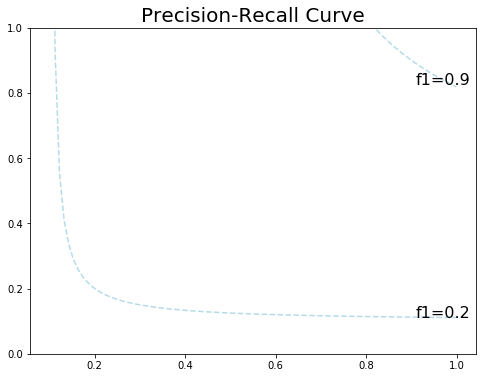

In [134]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(df_binary['binary_rating'], probs_bin,
                                    plot_micro=True,
                                    title_fontsize=20, text_fontsize=16,
                                    cmap=cmap,
                                    ax=ax
                                    )
ax.legend(loc=[1.1, 0])
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
skplt.metrics.plot_roc(tweets_test[['LANG']], probabilities,
                       plot_micro=True, plot_macro=True,
                       title_fontsize=20, text_fontsize=16,
                       figsize=(8, 6), cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

In [ ]:
#whats your model not getting right



predicted = pipeline.predict(tweets_df["TEXT"])

# Incorrectly classified
incorrect_preds = tweets_df[(predicted != tweets_df['LANG'])]
incorrect_preds = (predicted != tweets_df['LANG'])

incorrect_preds.shape

In [ ]:
incorrect_df = pd.DataFrame({'actual': tweets_df['LANG'],
                             'predicted': predicted,
                             'mismatch': incorrect_preds,
                             'TEXT': tweets_df.TEXT})

incorrect_df[incorrect_df.mismatch == True].head(10)

In [ ]:
incorrect_df[incorrect_df.mismatch == True].groupby(
    ['actual', 'predicted'])[['mismatch']].count()

<a name="conclusions"> </a>
# Binary classification problem

# Web scraped dataset (including price as feature)

- Ensure feature names are the same
- Make sure it's only cameras, splice on price <50 
df_clean = df_clean[df_clean['Price'] > 50]
- Remove sponsored ads by url begins with /gp/ or will removing duplicat ASINS be enough?


* Features Needed to match original dataset*

No but redundant

- marketplace
- vine
- product_parent (what is this)

No 
- total_votes (cant find it)
- customer_id (doesnt seem to be in the URL, amazon must have anonymised dataset)


Yes 
- review_id
- product_category (inferred from scrape)
- product_title (infer from product_id?)
- product_id (asin that i'm feeding in)
- star_rating
- review_headline
- review_body
- review_date
- helpful_votes
- verified_purchase


In [78]:
dslr = pd.read_csv('Scraped_data/DSLR.csv')
mirrorless = pd.read_csv('Scraped_data/MIRRORLESS.csv')
action = pd.read_csv('Scraped_data/ACTION.csv')
pos = pd.read_csv('Scraped_data/POINTANDSHOOT.csv')

dslr['camera_type'] = 'dslr'
mirrorless['camera_type'] = 'mirrorless'
action['camera_type'] = 'action'
pos['camera_type'] = 'point and shoot'

In [79]:
df_scraped = pd.concat([dslr, mirrorless, action], axis=0)

In [136]:
df_scraped.shape

(707, 7)

In [80]:
df_scraped = df_scraped[df_scraped['Product'].str.contains('Body')] #filter for camera bodies only

df_scraped = pd.concat([df_scraped, pos], axis=0) #add the point and shoot cameras

df_scraped.shape

(406, 7)

In [81]:
#duplicate values

df_scraped[df_scraped.duplicated(subset='ASIN')].shape

(25, 7)

In [82]:
# dropping ALL duplicte values 
df_scraped.drop_duplicates(subset ="ASIN", 
                     keep = 'first', inplace = True)

In [140]:
df_scraped.shape

(381, 7)

In [83]:
#column types
df_scraped['Reviews'] = df_scraped['Reviews'].astype('int64')




In [84]:
#First scrape three pages (30 reviews from those with over 30)
# df_scraped = df_scraped[df_scraped['Reviews'] > 35]

df_scraped = df_scraped[(df_scraped['Reviews'] > 10) & (df_scraped['Reviews'] < 30)]
df_scraped.shape


(63, 7)

In [85]:
df_scraped.isnull().sum()

ASIN           0
URL            0
Product        0
Reviews        0
Rating         0
Price          0
camera_type    0
dtype: int64

In [95]:
for asin in df_scraped.ASIN:
    reviewpages = 1
    review_scraper(asin, reviewpages)

observations before cleaning (10, 11)
observations after cleaning (10, 11)


NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=76.0.3809.132)


In [86]:
low_review_count = pd.read_csv('Scraped_data/reviews10.csv') #one page for each product having between 10 and 30 reviews
high_review_count = pd.read_csv('Scraped_data/reviews30.csv') #30 reviews for each product with more than 35 reviews


In [87]:
#Combine and clean

print(low_review_count.shape)
print(high_review_count.shape)

(686, 11)
(6447, 11)


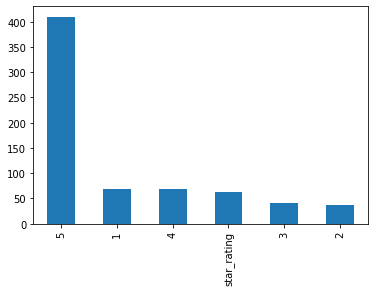

In [151]:
low_review_count.star_rating.value_counts().plot(kind='bar')

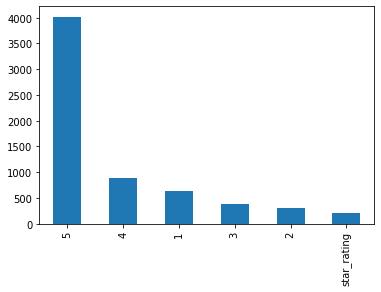

In [152]:
high_review_count.star_rating.value_counts().plot(kind='bar')

In [88]:
df_scraped_combined = pd.concat([low_review_count, high_review_count], axis=0) 
df_scraped_combined.shape

(7133, 11)

In [89]:
#What is star_rating
df_scraped_combined.star_rating.value_counts() 

5              4430
4               963
1               710
3               424
2               337
star_rating     269
Name: star_rating, dtype: int64

In [90]:
#Finds the headings, drop these rows!
df_scraped_combined[df_scraped_combined.star_rating == 'star_rating' ].head()

,ASIN,review_id,profile_name,user_url_id,review_date,star_rating,review_title,helpful_votes,total_comments,verified_purchase,review_body
10,ASIN,review_id,profile_name,user_url_id,review_date,star_rating,review_title,helpful_votes,total_comments,verified_purchase,review_body
19,ASIN,review_id,profile_name,user_url_id,review_date,star_rating,review_title,helpful_votes,total_comments,verified_purchase,review_body
30,ASIN,review_id,profile_name,user_url_id,review_date,star_rating,review_title,helpful_votes,total_comments,verified_purchase,review_body
41,ASIN,review_id,profile_name,user_url_id,review_date,star_rating,review_title,helpful_votes,total_comments,verified_purchase,review_body
52,ASIN,review_id,profile_name,user_url_id,review_date,star_rating,review_title,helpful_votes,total_comments,verified_purchase,review_body


In [91]:
df_scraped_combined = df_scraped_combined[df_scraped_combined.star_rating != 'star_rating' ]
df_scraped_combined.shape

(6864, 11)

In [169]:
df_scraped_combined

,ASIN,review_id,profile_name,user_url_id,review_date,star_rating,review_title,helpful_votes,total_comments,verified_purchase,review_body
0,B07QFFNCG4,R1IAYK4EHMWIZP,HarryB,/gp/profile/amzn1.account.AF3RYOV4DESZPEQILRXI...,"August 25, 2019",5,Excellent Camera,NaN,0,Verified Purchase,Excellent intermediate camera.Great auto expos...
1,B07QFFNCG4,R1S7BYTWFPHWCQ,IFLYMAUI,/gp/profile/amzn1.account.AFVSDBVHEO6YQLV6EUMA...,"May 5, 2019",4,"FAST, RESPONSIVE, LIGHWEIGHT AND SIMPLE",104,3,Verified Purchase,There isn't much to dislike about Canon's SL3 ...
2,B07QFFNCG4,R1Z7CIA01C9Q8T,Mikayla Hatfield,/gp/profile/amzn1.account.AFL75GRLLBS6PVADLGGW...,"June 18, 2019",5,I love it!,11,1,Verified Purchase,I am in love with this camera! Before I upgrad...
3,B07QFFNCG4,R26NAJXTSSZBUZ,xtcgrl401,/gp/profile/amzn1.account.AECRW4ZKMJ6NANUHPBWW...,"June 9, 2019",5,Nice,NaN,0,Verified Purchase,Does what it says. Very satisfied!\n
4,B07QFFNCG4,R2A9EXXPM84J7A,Ahmed Abdulameer,/gp/profile/amzn1.account.AGVVCEB5S3XYROYBEFRN...,"July 6, 2019",5,Small sturdy DSLR with 4K capability,7,0,Verified Purchase,An excellent choice for beginner/intermediate ...
5,B07QFFNCG4,R2WAEA0ZMYVSZ0,Kristina Karpew,/gp/profile/amzn1.account.AEC5QNXKWQIBRT6D4UI5...,"July 1, 2019",5,Love,NaN,0,Verified Purchase,What a great upgrade from my canon EOS t3\n
6,B07QFFNCG4,R3RO9XEAQJST4Q,Mindy,/gp/profile/amzn1.account.AGFRRU5OEVGC7O26BTTL...,"June 24, 2019",5,Starter Camera,6,0,Verified Purchase,Perfect camera for any amature photographers o...
7,B07QFFNCG4,R49OWQWMYH37H,Frangela-2,/gp/profile/amzn1.account.AEVC6NQC6XFBDISK6XAQ...,"June 20, 2019",4,Great entry level and intermediate camera.,9,0,Verified Purchase,I'm used to a Canon 5DM4 but bought this for a...
8,B07QFFNCG4,R5NZOHSK7OT00,Mohammad Yunus Naseri,/gp/profile/amzn1.account.AHDKBU3JU7ZF32O6QXZX...,"August 22, 2019",4,Odd smell,NaN,0,Verified Purchase,"I found the camera a quality one. However, as ..."
9,B07QFFNCG4,RFP5B1SNHV2FH,GenerousDad77,/gp/profile/amzn1.account.AEIWQAPD7AACI5BMWTXI...,"July 3, 2019",5,A great beginner camera,6,0,Verified Purchase,This is a great camera for all levels and you ...


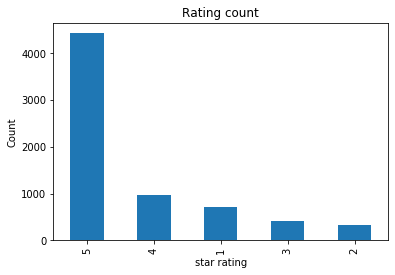

In [92]:
df_scraped_combined.star_rating.value_counts().plot(kind='bar')
plt.xlabel("star rating")
plt.ylabel('Count')
plt.title('Rating count')
plt.show()

In [175]:
df_scraped_combined.isnull().sum()

ASIN                    0
review_id               0
profile_name            1
user_url_id             0
review_date             0
star_rating             0
review_title            0
helpful_votes        1296
total_comments         14
verified_purchase     233
review_body             0
dtype: int64